# XGBoost

In this tutorial we learn how to process data, train an XGBoost model and validate any model.

# Import packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from pathlib import Path

In [3]:
# set width of Jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# set some visual properties of displaying pandas DataFrame
pd.options.display.max_columns=200
pd.options.display.max_rows=200

**Download the data if needed (and unpack it into the Data folder), we use the same dataset as in the python intro:** <a href="https://www2.karlin.mff.cuni.cz/~kozmikk/files/data_devsample.zip" target="_blank">credit risk data</a> 

# Load Data
- Data sample represents data used in financial institutions for development of credit risk scoring models.
- This data sample was used in Kaggle competition arranged by Home Credit Group in 2018.
- Data includes binary target variable `TARGET` and multiple regressors to be used in model.
- Column `SK_ID_CURR` is used as unique identifier of credit application and columns `TIME` represents time of the application.
- Model should predict solvency of applicants at the time of application for credit.

In [100]:
# Load data - set index column, decimal point, separator
data_file = Path("../Data/2024_DS2_HW1_data_train.csv")
data = pd.read_csv(data_file, sep = ',', decimal = '.', index_col = 'Booking_ID')

# print time of data being loaded - use strftime
print(f'Data loaded on:   {datetime.datetime.now().strftime(format="%Y-%m-%d %H:%M:%S")}')

Data loaded on:   2024-04-15 16:29:02


In [101]:
data.head()

no_of_adults  no_of_children  no_of_weekend_nights  \
Booking_ID                                                       
INN10204             NaN             NaN                   NaN   
INN20020             NaN             NaN                   NaN   
INN16435             1.0             NaN                   NaN   
INN07143             3.0             NaN                   NaN   
INN20511             1.0             0.0                   1.0   

            no_of_week_nights type_of_meal_plan  required_car_parking_space  \
Booking_ID                                                                    
INN10204                  2.0       Meal Plan 2                         NaN   
INN20020                  2.0       Meal Plan 1                         NaN   
INN16435                  2.0               NaN                         0.0   
INN07143                  3.0               NaN                         NaN   
INN20511                  1.0       Meal Plan 1                         0.0   

           room_type_reserved  lead_time  arrival_year  arrival_month  \
Booking_ID                                                              
INN10204          Room_Type 6        NaN        2018.0            9.0   
INN20020                  NaN        NaN           NaN           12.0   
INN16435          Room_Type 1        NaN        2018.0           11.0   
INN07143                  NaN      100.0        2018.0            5.0   
INN20511                  NaN        NaN        2018.0           11.0   

            arrival_date market_segment_type  repeated_guest  \
Booking_ID                                                     
INN10204             NaN              Online             0.0   
INN20020             NaN              Online             0.0   
INN16435             NaN                 NaN             0.0   
INN07143             NaN              Online             0.0   
INN20511             NaN                 NaN             0.0   

            no_of_previous_cancellations  \
Booking_ID                                 
INN10204                             0.0   
INN20020                             0.0   
INN16435                             0.0   
INN07143                             0.0   
INN20511                             0.0   

            no_of_previous_bookings_not_canceled  avg_price_per_room  \
Booking_ID                                                             
INN10204                                     NaN                 NaN   
INN20020                                     0.0                 NaN   
INN16435                                     NaN                 NaN   
INN07143                                     NaN                 NaN   
INN20511                                     0.0               150.0   

            no_of_special_requests  booking_status  
Booking_ID                                          
INN10204                       1.0             0.0  
INN20020                       NaN             0.0  
INN16435                       1.0             0.0  
INN07143                       2.0             0.0  
INN20511                       NaN             1.0

In [102]:
# Print some numbers about data sample size
print(f'Number of rows:   {data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {data.shape[1]:,}'.replace(',', ' '))

Number of rows:   32 647
Number of unique indexes:   32 647
Number of columns:   18


# Metadata Definitions

In [103]:
# check values in column TARGET
data.booking_status.value_counts(dropna=False)

booking_status
0.0    21774
1.0    10521
NaN      352
Name: count, dtype: int64

In [104]:
data = data.dropna(subset = ['booking_status'])

In [105]:
#name of the target column
col_target = "booking_status"

#name of the month column
col_month = 'arrival_month_filled'

In [127]:
# Roky jsem zahodil, u dnů chybí hrozně moc dat, takže použivam jen měsíce. Je třeba fillnout missing values.

In [110]:
data['arrival_month_filled'] = data['arrival_month'].fillna("N/A")

In [112]:
# define list of predictors
cols_pred = list(data.columns[1:8]) + list(data.columns[12:17])
cols_pred.append('arrival_month_filled')

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']

print('Numerical predictors:')
print('---------------------')
print(data[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_pred_cat].dtypes)

Numerical predictors:
---------------------
no_of_children                          float64
no_of_weekend_nights                    float64
no_of_week_nights                       float64
required_car_parking_space              float64
lead_time                               float64
repeated_guest                          float64
no_of_previous_cancellations            float64
no_of_previous_bookings_not_canceled    float64
avg_price_per_room                      float64
no_of_special_requests                  float64
dtype: object

Categorical predictors:
-----------------------
type_of_meal_plan       object
room_type_reserved      object
arrival_month_filled    object
dtype: object


# Data Split

In [113]:
# define function to plot default rate in time for different samples
def default_rate_in_time_per_sample(dt, col_target, col_month, col_sample):
    # group by over month and sample
    dt_grp = dt.groupby([col_month, col_sample]).agg(
        def_rt = (col_target, 'mean')
    ).reset_index()
    
    # pivot sample values to columns
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = col_sample, values = 'def_rt')

    # plot default rate in time
    lines = plt.plot(range(len(dt_grp_pivot)), dt_grp_pivot, marker = 'o')
    plt.xticks(range(len(dt_grp_pivot)), dt_grp_pivot.index, rotation = 90)
    # set legend
    plt.legend(iter(lines), tuple(dt_grp_pivot.columns), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.ylim([0, 0.5])
    plt.ylabel('default rate')
    plt.xlabel('month')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray')
        
    plt.show()

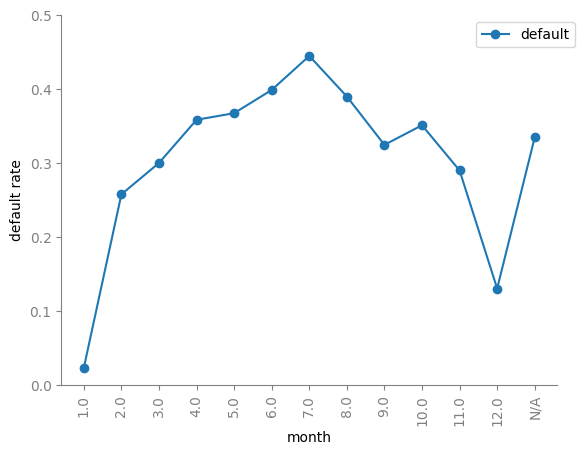

In [114]:
data['sample'] = 'default'
default_rate_in_time_per_sample(data, col_target,'arrival_month_filled', 'sample')

In [115]:
data['sample'] = 'default'

# define 'hoot' and 'oot' sample
#data.loc[data[col_month] <= 201701, 'sample'] = 'hoot'
#data.loc[data[col_month] >= 201911, 'sample'] = 'oot'

# define intime mask
#intime_mask = (data[col_month] > 201701) & (data[col_month] < 201911)
# use train_test_split to split the intime into train and rest (don't forget seed); use stratification
data_train, data_rest = train_test_split(data, test_size=0.4, random_state = 12, stratify = (data[[col_month, col_target]]))
data.loc[data_train.index, 'sample'] = 'train'
# use train_test_split to split the rest into valid and test (don't forget seed); use stratification
data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 12, stratify = (data_rest[[col_month, col_target]]))
data.loc[data_valid.index, 'sample'] = 'valid'
data.loc[data_test.index, 'sample'] = 'test'

## Define Sample Masks

In [116]:
# define sample masks
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid') 
test_mask = (data['sample'] == 'test') 
oot_mask = (data['sample'] == 'oot')  
hoot_mask = (data['sample'] == 'hoot')

# Data preprocessing

## Encode Categorical Predictors- XGBOOST NEUMI KATEGORIE - MUSIME PREVEST NA SPOJITE
- Category encoding is defined by:
$$ CategoryEncoding = \frac{f_{categ}\cdot DR_{category} + \alpha \cdot DR}{f_{categ} + \alpha} $$
where $f_{categ}$ is frequency of category to be encoded, $DR_{category}$ default rate in this category and $DR$ is total default rate.

In [117]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_dr = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_dr = (target, 'mean'),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_dr'] + alpha * total_dr) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [118]:
total_dr = np.mean(data[train_mask][col_target])

# encode categorical predictors
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_dr

        data['MTE_' + pred] = data[pred].map(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/3 [00:00<?, ?it/s]

In [119]:
cols_pred

['no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'MTE_type_of_meal_plan',
 'MTE_room_type_reserved',
 'MTE_arrival_month_filled']

# XGBoost model
- XGBoost model is provided in package `xgboost`
- https://xgboost.readthedocs.io/en/stable/

## First XGBoost model
- **early stopping:** Model is trained on training sample and we control model performance on evaluation sample (can be valid or test). If the model does not improve after *n* iterations, we stop the training.
- Data must be passed to training as *xgb.DMatrix* data type.
- Parameter *dtrain* defines data set to be used for training. Parameter evals is used for passing evaluation data sets - eval_metric will be evaluated on those sets in each iteration. Last data set from evals is used for early stopping.

In [120]:
# set best parameters to be used in XGBoost
params = {    
    'max_depth': 4, # ?
    
    'objective': 'binary:logistic', # default je 'reg:squarederror', binary:logistic se pouziva na pravdepodobnosti (logisticka regrese)
    'eval_metric': ['auc'],
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)

[0]	train-auc:0.69806	test-auc:0.69936	valid-auc:0.69463
[1]	train-auc:0.72080	test-auc:0.71995	valid-auc:0.71604
[2]	train-auc:0.72983	test-auc:0.72830	valid-auc:0.72544
[3]	train-auc:0.73407	test-auc:0.73085	valid-auc:0.72677
[4]	train-auc:0.73793	test-auc:0.73447	valid-auc:0.73198
[5]	train-auc:0.74218	test-auc:0.73920	valid-auc:0.73657
[6]	train-auc:0.74538	test-auc:0.74257	valid-auc:0.73901
[7]	train-auc:0.74878	test-auc:0.74513	valid-auc:0.74159
[8]	train-auc:0.74989	test-auc:0.74641	valid-auc:0.74381
[9]	train-auc:0.75221	test-auc:0.74779	valid-auc:0.74427
[10]	train-auc:0.75293	test-auc:0.74875	valid-auc:0.74539
[11]	train-auc:0.75383	test-auc:0.74918	valid-auc:0.74611
[12]	train-auc:0.75526	test-auc:0.74922	valid-auc:0.74758
[13]	train-auc:0.75572	test-auc:0.75001	valid-auc:0.74824
[14]	train-auc:0.75700	test-auc:0.75119	valid-auc:0.74921
[15]	train-auc:0.75812	test-auc:0.75191	valid-auc:0.75049
[16]	train-auc:0.76090	test-auc:0.75475	valid-auc:0.75215
[17]	train-auc:0.76198	t

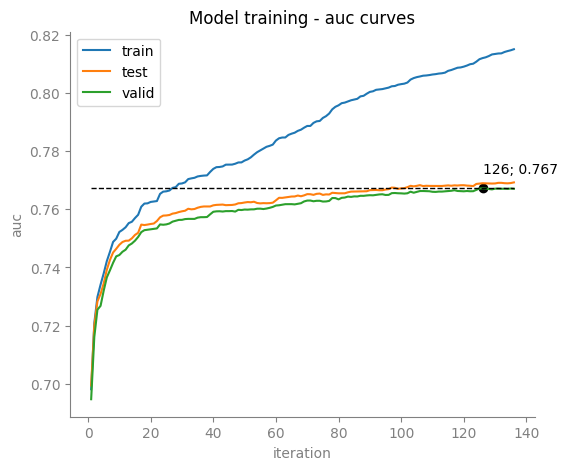

In [121]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

# plt.savefig('test.svg', format='svg')
# plt.close()

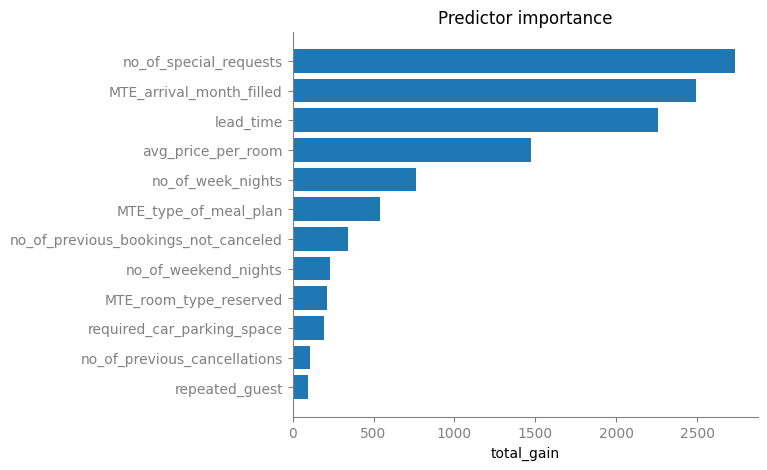

In [122]:
importance_type = 'total_gain' # TOTO NENÍ DOBRÉ POUŽÍVAT, PROTOŽE TO DŮLEŽITÝM PREDIKTORŮM MŮŽE DÁT NÍZKÉ HODNOTY. CELKOVĚ TO PREFERUJE PRVNÍ STROM.

predictor_strength = sorted([(k, v) for k,v in booster.get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])

fig = plt.figure(figsize=(6,5))

n_strongest = 12
plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:12])
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:12])
plt.xlabel(importance_type)
plt.title('Predictor importance')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()

<span style="color:red">**TO DO:** change the hyperparameters and observe performance and training</span>

https://xgboost.readthedocs.io/en/stable/parameter.html PARAMETRY INFO

## XGBoost in sklearn

In [22]:
booster_sklearn = xgb.XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    random_state=12,
    verbosity=1,
    eval_metric='auc',
    use_label_encoder=False,
    early_stopping_rounds=10,
)

booster_sklearn.fit(
    data[train_mask][cols_pred].values, 
    data[train_mask][col_target].astype(int).values,
    eval_set=[
        (data[train_mask][cols_pred].values, data[train_mask][col_target].values),
        (data[test_mask][cols_pred].values, data[test_mask][col_target].values),
        (data[valid_mask][cols_pred].values, data[valid_mask][col_target].values),
    ],
    verbose=True,
)

[0]	validation_0-auc:0.72694	validation_1-auc:0.72245	validation_2-auc:0.71841
[1]	validation_0-auc:0.73926	validation_1-auc:0.73236	validation_2-auc:0.72560
[2]	validation_0-auc:0.74676	validation_1-auc:0.73967	validation_2-auc:0.73226
[3]	validation_0-auc:0.75590	validation_1-auc:0.74283	validation_2-auc:0.73712
[4]	validation_0-auc:0.76059	validation_1-auc:0.74789	validation_2-auc:0.74235
[5]	validation_0-auc:0.76588	validation_1-auc:0.75169	validation_2-auc:0.74521
[6]	validation_0-auc:0.76870	validation_1-auc:0.75379	validation_2-auc:0.74818
[7]	validation_0-auc:0.77026	validation_1-auc:0.75536	validation_2-auc:0.74891
[8]	validation_0-auc:0.77205	validation_1-auc:0.75697	validation_2-auc:0.75003
[9]	validation_0-auc:0.77351	validation_1-auc:0.75752	validation_2-auc:0.75151
[10]	validation_0-auc:0.77714	validation_1-auc:0.76038	validation_2-auc:0.75295
[11]	validation_0-auc:0.77848	validation_1-auc:0.76071	validation_2-auc:0.75350
[12]	validation_0-auc:0.77938	validation_1-auc:0.7

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=12, ...)

## Final model
Before fitting final model, selection of optimal predictors might be considered. A model with similar performance can be fitted using *n* strongest predictors or using all available predictors. Sometime implementation of the predictors into the production might take some time and therefore you prefer to have "reasonable" number of predictors in your model. On the contrary, having larger number of predictors might bring better robustness - if one of the predictors would broke, the impact for the model would be lower.

For selection of optimal predictors, similar approach as forward (or backward) process can be used.

### Cross validation score

In [123]:
params={
    'eta': 0.1,
    'max_depth': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

skf = StratifiedKFold(n_splits = 2, shuffle = True, random_state = 12)

X = data[cols_pred].values
y = data[col_target].values
data['cv_score'] = -1.0
cv_res = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    evals_result = {}
    booster = xgb.train(
        params = params,
        dtrain = xgb.DMatrix(X_train, y_train),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(X_train, y_train), 'train'),
            (xgb.DMatrix(X_test, y_test), 'test'),
        ),
        evals_result = evals_result,
        early_stopping_rounds = 10,
        verbose_eval = True
    )
    
    gini_train = 2 * roc_auc_score(y_train, booster.predict(xgb.DMatrix(X_train))) - 1
    gini_test  = 2 * roc_auc_score(y_test,  booster.predict(xgb.DMatrix(X_test)))  - 1
    best_iteration = booster.best_iteration
    
    cv_res += [(gini_train, gini_test, best_iteration)]
    
    data.iloc[test_index, list(data.columns).index('cv_score')] = list(booster.predict(xgb.DMatrix(X_test), iteration_range=(0, booster.best_iteration)))

[0]	train-auc:0.64180	test-auc:0.63444
[1]	train-auc:0.71385	test-auc:0.71073
[2]	train-auc:0.72257	test-auc:0.71965
[3]	train-auc:0.72754	test-auc:0.72178
[4]	train-auc:0.73146	test-auc:0.72538
[5]	train-auc:0.73159	test-auc:0.72586
[6]	train-auc:0.73206	test-auc:0.72669
[7]	train-auc:0.73129	test-auc:0.72550
[8]	train-auc:0.73515	test-auc:0.72825
[9]	train-auc:0.74040	test-auc:0.73228
[10]	train-auc:0.74166	test-auc:0.73267
[11]	train-auc:0.74319	test-auc:0.73467
[12]	train-auc:0.74342	test-auc:0.73511
[13]	train-auc:0.74412	test-auc:0.73576
[14]	train-auc:0.74518	test-auc:0.73691
[15]	train-auc:0.74558	test-auc:0.73712
[16]	train-auc:0.74596	test-auc:0.73718
[17]	train-auc:0.74711	test-auc:0.73794
[18]	train-auc:0.74844	test-auc:0.73910
[19]	train-auc:0.74981	test-auc:0.74027
[20]	train-auc:0.75058	test-auc:0.74105
[21]	train-auc:0.75090	test-auc:0.74102
[22]	train-auc:0.75134	test-auc:0.74169
[23]	train-auc:0.75212	test-auc:0.74248
[24]	train-auc:0.75297	test-auc:0.74349
[25]	train

In [124]:
# Performance during cross validation
cv_res

[(0.6100319004666326, 0.5216071399046731, 232),
 (0.6000063516443135, 0.5208320454751036, 206)]

In [125]:
gini_cv = 2 * roc_auc_score(data[col_target], data['cv_score']) - 1
print(f'Cross validation score performance: {gini_cv:.4f}')

Cross validation score performance: 0.5212


In [126]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 4,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[cols_pred], data[col_target]),
    evals = (
        (xgb.DMatrix(data[cols_pred], data[col_target]), 'train'),
    ),
    num_boost_round = 130,
    evals_result = evals_result
)

[0]	train-auc:0.63627
[1]	train-auc:0.64514
[2]	train-auc:0.71194
[3]	train-auc:0.71463
[4]	train-auc:0.72723
[5]	train-auc:0.73241
[6]	train-auc:0.73263
[7]	train-auc:0.73772
[8]	train-auc:0.73936
[9]	train-auc:0.73982
[10]	train-auc:0.74007
[11]	train-auc:0.73972
[12]	train-auc:0.74077
[13]	train-auc:0.74145
[14]	train-auc:0.74281
[15]	train-auc:0.74341
[16]	train-auc:0.74427
[17]	train-auc:0.74421
[18]	train-auc:0.74510
[19]	train-auc:0.74671
[20]	train-auc:0.74716
[21]	train-auc:0.74786
[22]	train-auc:0.74819
[23]	train-auc:0.74846
[24]	train-auc:0.74865
[25]	train-auc:0.74885
[26]	train-auc:0.74935
[27]	train-auc:0.74964
[28]	train-auc:0.75002
[29]	train-auc:0.75036
[30]	train-auc:0.75056
[31]	train-auc:0.75106
[32]	train-auc:0.75147
[33]	train-auc:0.75160
[34]	train-auc:0.75247
[35]	train-auc:0.75309
[36]	train-auc:0.75388
[37]	train-auc:0.75425
[38]	train-auc:0.75464
[39]	train-auc:0.75504
[40]	train-auc:0.75512
[41]	train-auc:0.75586
[42]	train-auc:0.75616
[43]	train-auc:0.7564

In [143]:
gini_train = 2 * roc_auc_score(data[col_target], booster.predict(xgb.DMatrix(data[cols_pred]))) - 1
print(gini_train)

0.49122339940483206


### Final model using splitted data

In [144]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': ['logloss', 'auc'],
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12,
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 300,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred],  data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10,
    verbose_eval = True
)

[0]	train-logloss:0.62690	train-auc:0.56910	test-logloss:0.62725	test-auc:0.56788	valid-logloss:0.62670	valid-auc:0.57383
[1]	train-logloss:0.62336	train-auc:0.57668	test-logloss:0.62389	test-auc:0.57238	valid-logloss:0.62297	valid-auc:0.58284
[2]	train-logloss:0.61677	train-auc:0.67162	test-logloss:0.61740	test-auc:0.67304	valid-logloss:0.61670	valid-auc:0.67610
[3]	train-logloss:0.61113	train-auc:0.69989	test-logloss:0.61188	test-auc:0.69953	valid-logloss:0.61171	valid-auc:0.69450
[4]	train-logloss:0.60557	train-auc:0.70305	test-logloss:0.60645	test-auc:0.70233	valid-logloss:0.60630	valid-auc:0.69761
[5]	train-logloss:0.60127	train-auc:0.70314	test-logloss:0.60194	test-auc:0.70244	valid-logloss:0.60184	valid-auc:0.69779
[6]	train-logloss:0.59996	train-auc:0.70668	test-logloss:0.60077	test-auc:0.70596	valid-logloss:0.60062	valid-auc:0.70190
[7]	train-logloss:0.59629	train-auc:0.70647	test-logloss:0.59680	test-auc:0.70558	valid-logloss:0.59687	valid-auc:0.70125
[8]	train-logloss:0.5943

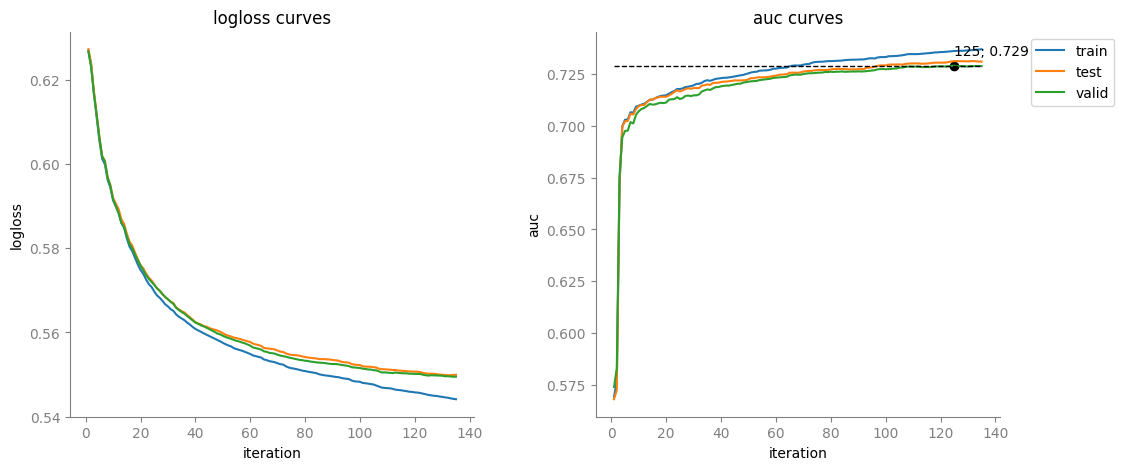

In [145]:
metric = 'logloss'

fig, axs = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(wspace=0.3)

total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    axs[0].plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

    
for sample, vals in evals_result.items():
    axs[1].plot(
        range(1, total_iteration_count + 1), 
        vals['auc'],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)

axs[0].set_xlabel('iteration')
axs[0].set_ylabel('logloss')
axs[0].set_title(f'logloss curves')

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['left'].set_color('gray')
axs[0].spines['bottom'].set_color('gray')
axs[0].tick_params(axis='y', colors='gray')
axs[0].tick_params(axis='x', colors='gray')

axs[1].set_xlabel('iteration')
axs[1].set_ylabel('auc')
axs[1].set_title(f'auc curves')

axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_color('gray')
axs[1].spines['bottom'].set_color('gray')
axs[1].tick_params(axis='y', colors='gray')
axs[1].tick_params(axis='x', colors='gray')

plt.legend(loc='upper right',  bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))

plt.show()

#### Applying monotone constraints

<span style="color:red">**TO DO:** Define function for marginal dependence.</span>

Function should have following input parameters:
- data ... pd.DataFrame with data to be used for marginal dependence calculation, TARGET is included in this dataframe
- predictor ... name of the predictor to be analysed
- bins ... number of bins to split the predictor into
- col_target ... the TARGET column to compute default date


It should output a graph with the default rate for each bin, for example
marginal_dependence(data[train_mask], 'EXT_SOURCE_1', 10, col_target) should give something like

<img src="marginal_dependence.png" width=400px style="float: left"/>




In [63]:
def marginal_dependence(data, predictor, bins, col_target):
    dt = data.copy()
    dt[predictor + 'bin'] = pd.qcut(dt[predictor], bins).copy()
    dt.groupby(predictor + 'bin').agg(
        def_rt=(col_target, np.mean),
    ).plot(figsize=(9, 6))

In [64]:
positive_monotone_constraint = [
]

negative_monotone_constraint = [
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3'
]

constr = []
for col in cols_pred:
    if col in positive_monotone_constraint:
        constr.append('1')
    elif col in negative_monotone_constraint:
        constr.append('-1')
    else:
        constr.append('0')

constr = '(' + ','.join(constr) + ')'
constr

'(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)'

In [65]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'monotone_constraints': constr,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred],  data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10,
    verbose_eval = True
)

[0]	train-auc:0.60428	test-auc:0.58660	valid-auc:0.60098
[1]	train-auc:0.70409	test-auc:0.69029	valid-auc:0.70429
[2]	train-auc:0.70978	test-auc:0.69977	valid-auc:0.70995
[3]	train-auc:0.72083	test-auc:0.70839	valid-auc:0.72054
[4]	train-auc:0.72055	test-auc:0.70766	valid-auc:0.71945
[5]	train-auc:0.72007	test-auc:0.70742	valid-auc:0.71915
[6]	train-auc:0.72142	test-auc:0.70605	valid-auc:0.71965
[7]	train-auc:0.72419	test-auc:0.70581	valid-auc:0.72280
[8]	train-auc:0.72333	test-auc:0.70537	valid-auc:0.72237
[9]	train-auc:0.72791	test-auc:0.70840	valid-auc:0.72671
[10]	train-auc:0.72850	test-auc:0.70745	valid-auc:0.72717
[11]	train-auc:0.72822	test-auc:0.70821	valid-auc:0.72672
[12]	train-auc:0.72966	test-auc:0.71060	valid-auc:0.72905
[13]	train-auc:0.73092	test-auc:0.71073	valid-auc:0.73082
[14]	train-auc:0.73207	test-auc:0.71312	valid-auc:0.73106
[15]	train-auc:0.73208	test-auc:0.71345	valid-auc:0.73052
[16]	train-auc:0.73268	test-auc:0.71460	valid-auc:0.73075
[17]	train-auc:0.73295	t

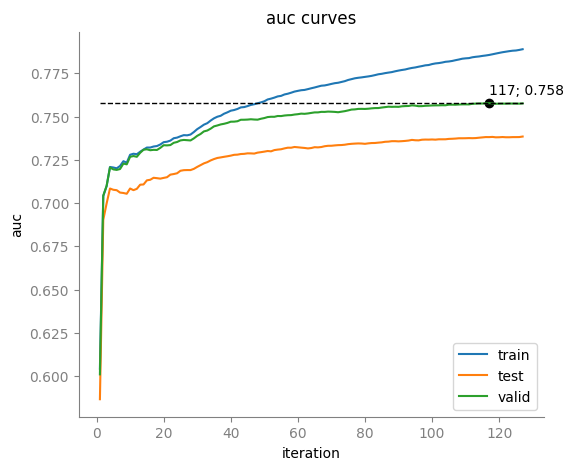

In [66]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    plt.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)
plt.xlabel('iteration')
plt.ylabel(metric)
plt.legend(loc='best')
plt.title(f'{metric} curves')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()

# Model validation

In [147]:
data['predicted_pd'] = booster.predict(xgb.DMatrix(data[cols_pred]), iteration_range=(0,booster.best_iteration))
data['predicted_score'] = np.log(data['predicted_pd'] / (1 - data['predicted_pd']))

AttributeError: `best_iteration` is only defined when early stopping is used.

## Plot individual trees

ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

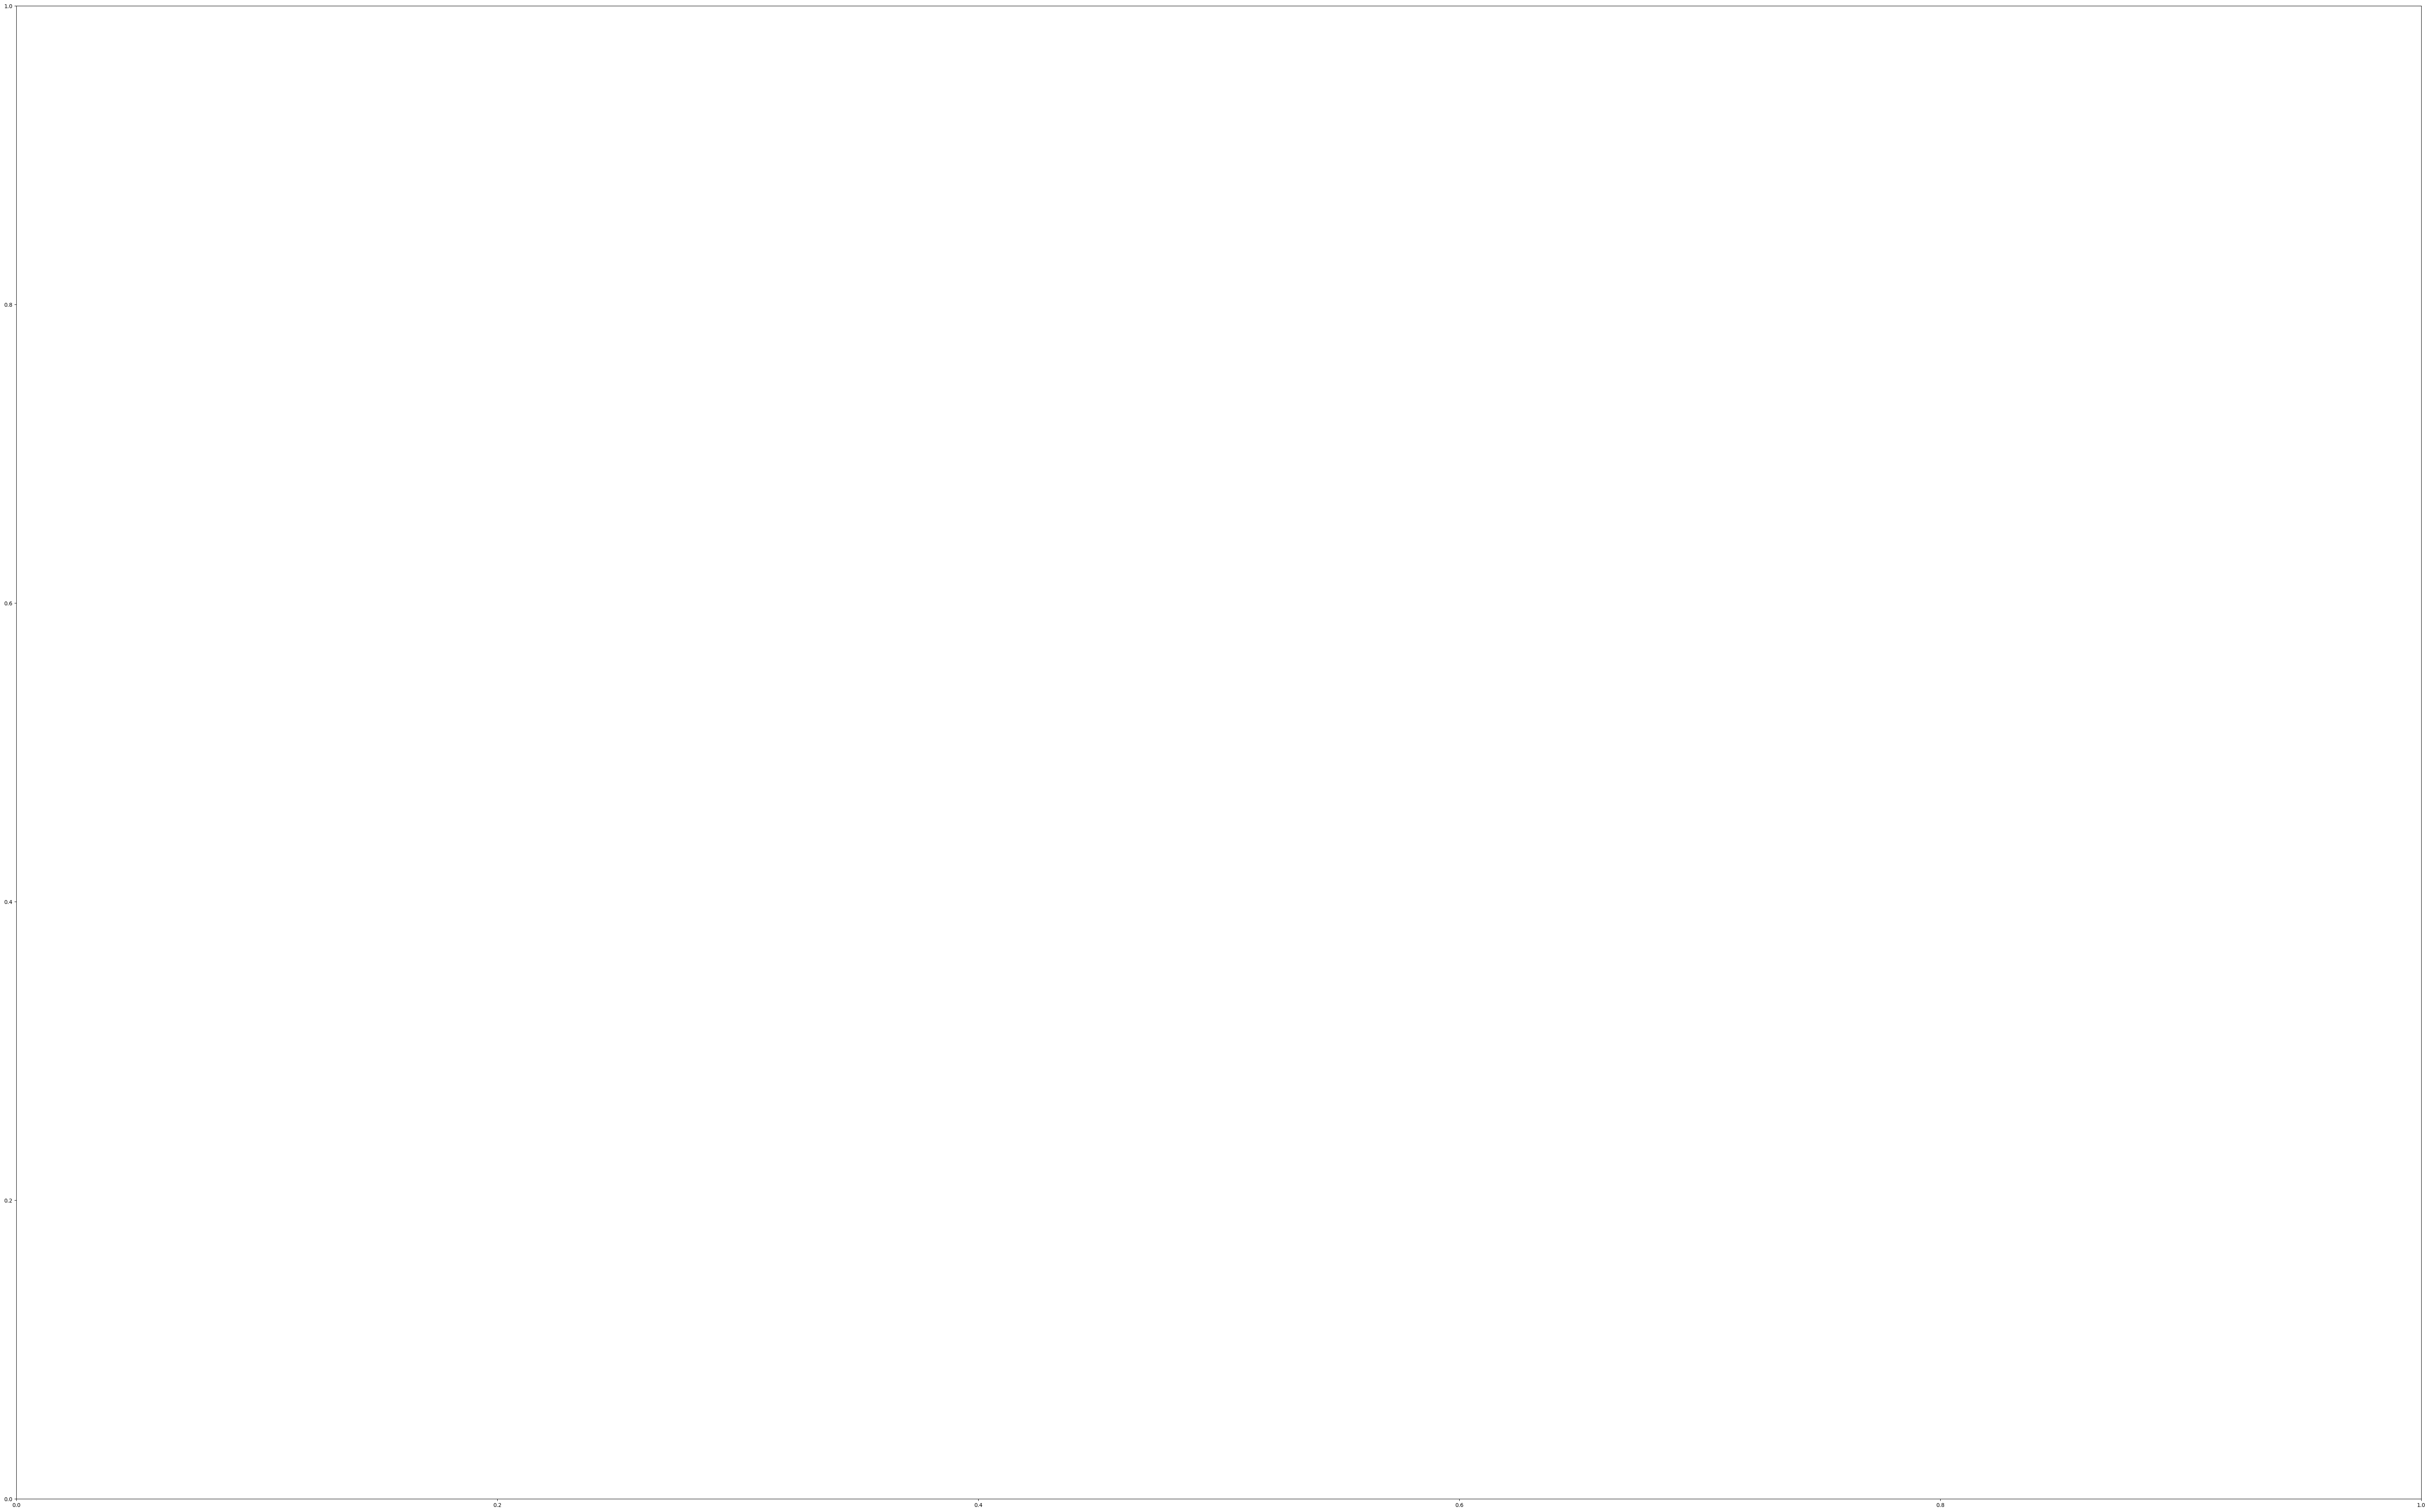

In [68]:
# TODO: To make the following line work you need to install graphviz (if you have not done so in one of the previous classes)
# 1) follow the instructions https://graphviz.gitlab.io/download/?fbclid=IwAR1V-lrRhho5rSfBVYXYISsighqRwOCOgMHLmL_DclkQrPtMXQaKj3mFcqs
# 2) this notebook has been tested with version 8.0.3
# 3) make sure you add it to the PATH variable (you are specifically asked during the installation) at least for local user

from xgboost import plot_tree
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50

plot_tree(booster, num_trees = 0)
plt.show()

rcParams['figure.figsize'] = 5,5

## Score distribution

In [69]:
def plot_score_calibration(dt, col_score, col_target, n_bins = 25):
    min_score = dt[col_score].min() - 0.1
    max_score = dt[col_score].max() + 0.1
    
    bins = [round(min_score + i * (max_score - min_score) / n_bins, 2) for i in range(n_bins+1)]
    dt = dt.assign(score_bin = pd.cut(dt[col_score], bins = bins, include_lowest = False))
    
    dt_grp = dt.groupby('score_bin', observed=False).agg(
        bad_cnt = (col_target, 'sum'),
        tot_cnt = (col_target, len),
        def_rt = (col_target, 'mean'),
        avg_score = (col_score, 'mean')
    )
    dt_grp['good_cnt'] = dt_grp['tot_cnt'] - dt_grp['bad_cnt']
    dt_grp['bad_cnt_norm'] = dt_grp['bad_cnt'] / dt_grp['tot_cnt']
    dt_grp['good_cnt_norm'] = dt_grp['good_cnt'] / dt_grp['tot_cnt']
    dt_grp['expected_pd'] = 1 / (1 + np.exp(-dt_grp['avg_score']))
    
    fig, axs = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle(col_score)
    plt.subplots_adjust(wspace = 0.4)
    axs[0].bar(range(len(dt_grp)), dt_grp['bad_cnt'], color = 'salmon', label = 'bads')
    axs[0].bar(range(len(dt_grp)), dt_grp['good_cnt'], bottom = dt_grp['bad_cnt'], color = 'lightblue', label = 'goods')
    axs[0].set_ylabel('observations count')
    axs[0].set_xlabel('score')
    axs[0].set_xticks(range(len(dt_grp)))
    axs[0].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[0].spines['right'].set_color('gray')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_color('gray')
    axs[0].spines['bottom'].set_color('gray')
    axs[0].tick_params(axis='y', colors='gray')
    axs[0].tick_params(axis='x', colors='gray')
    
    ax0l = axs[0].twinx()
    ax0l.plot(range(len(dt_grp)), dt_grp['def_rt'], marker = 'o', color = 'red')
    ax0l.plot(range(len(dt_grp)), dt_grp['expected_pd'], color = 'black', ls = '--')
    ax0l.set_ylabel('default rate', color = 'red')
    
    ax0l.spines['right'].set_color('gray')
    ax0l.spines['top'].set_visible(False)
    ax0l.spines['left'].set_color('gray')
    ax0l.spines['bottom'].set_color('gray')
    ax0l.tick_params(axis='y', colors='gray')
    ax0l.tick_params(axis='x', colors='gray')
    
    axs[1].bar(range(len(dt_grp)), dt_grp['bad_cnt_norm'], color = 'salmon', label = 'bads')
    axs[1].bar(range(len(dt_grp)), dt_grp['good_cnt_norm'], bottom = dt_grp['bad_cnt_norm'], color = 'lightblue', label = 'goods')
    axs[1].set_ylabel('frequency')
    axs[1].set_xlabel('score')
    axs[1].set_xticks(range(len(dt_grp)))
    axs[1].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_color('gray')
    axs[1].spines['bottom'].set_color('gray')
    axs[1].tick_params(axis='y', colors='gray')
    axs[1].tick_params(axis='x', colors='gray')

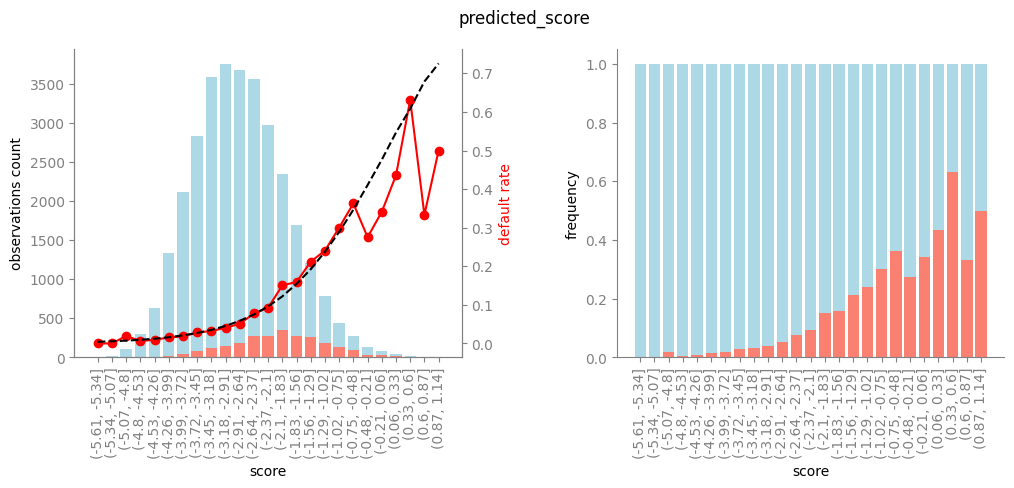

In [70]:
plot_score_calibration(data[valid_mask | test_mask], 'predicted_score', col_target)

## Permutation importance
- Let's have dataset $D$ and model with score (AUC for instance) $s$
- For each feature $j$ calculate permutation importance as follows:
    - for $k$ in $1,\ldots,K$:
        - shuffle column $j$ in dataset $D$ -> $\hat{D}_{k,j}$
        - compute the score $s_{k,j}$ using $\hat{D}_{k,j}$
    - importance $i_j$ for feature $f_j$ is defined as:
$$i_j = s - \frac{1}{K}\sum_{k=1}^K s_{k,j}$$

In [71]:
from sklearn.inspection import permutation_importance

In [72]:
# for sklearn, there is a function
r = permutation_importance(booster_sklearn, data[test_mask][cols_pred], data[test_mask][col_target], n_repeats=6)

In [73]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{cols_pred[i]:<8}    "
              f"{r.importances_mean[i]:.4f}"
              f" +/- {r.importances_std[i]:.4f}")

AMT_CREDIT    0.0006 +/- 0.0003
DAYS_EMPLOYED    0.0004 +/- 0.0002
APARTMENTS_MEDI    0.0001 +/- 0.0000
REGION_RATING_CLIENT_W_CITY    0.0001 +/- 0.0000
FIRST_TRANSACTION_TIME_MONTHS    0.0001 +/- 0.0000
YEARS_BEGINEXPLUATATION_MEDI    0.0001 +/- 0.0000


In [74]:
def permutation_importance(dt, predictor, target, model, n_iters = 10):
    predictors = list(dt.columns)
    predictors.remove(target)
    
    prediction = model.predict(xgb.DMatrix(dt[predictors]), iteration_range=(0,model.best_iteration))
    s = roc_auc_score(dt[target], prediction)
    
    sk = []
    for i in range(n_iters):
        x = dt[predictor].to_list()
        np.random.shuffle(x)
        dt[predictor] = x
        prediction = model.predict(xgb.DMatrix(dt[predictors]), iteration_range=(0,model.best_iteration))
        sk.append(roc_auc_score(dt[target], prediction))
    
    sk_mean = np.mean(sk)
    sk_perc05 = np.percentile(sk, q=5)
    sk_perc95 = np.percentile(sk, q=95)
    
    return s - sk_mean, s - sk_perc05, s - sk_perc95    

In [75]:
res = []
for pred in tqdm(cols_pred[0:10]):
    pi, iqr95, iqr05 = permutation_importance(
        dt=data[test_mask][cols_pred + [col_target]], 
        predictor=pred,
        target=col_target,
        model=booster,
        n_iters=10
    )
    res.append((pred, pi, iqr05, iqr95))
res = pd.DataFrame(res, columns = ['predictor', 'permutation_importance', 'iqr05', 'iqr95'])
res

  0%|          | 0/10 [00:00<?, ?it/s]

predictor  permutation_importance     iqr05     iqr95
0                CNT_CHILDREN                0.000013 -0.000048  0.000054
1            AMT_INCOME_TOTAL               -0.000013 -0.000168  0.000200
2                  AMT_CREDIT                0.004229  0.002822  0.005403
3                 AMT_ANNUITY                0.004086  0.002790  0.005345
4             AMT_GOODS_PRICE                0.007901  0.006385  0.010273
5  REGION_POPULATION_RELATIVE               -0.000027 -0.000202  0.000188
6                  DAYS_BIRTH                0.001934  0.001506  0.002296
7               DAYS_EMPLOYED                0.002849  0.001719  0.003857
8           DAYS_REGISTRATION               -0.000053 -0.000760  0.000315
9             DAYS_ID_PUBLISH                0.000688  0.000090  0.001049

## Marginal contribution - ODENDÁ regresor a udělá model bez něj a kouká jak moc se zhoršil. Může se ale např. stát že tam jsou 2 podobné velmi důležité proměnné ale odstranění jen jedné z nich doplní ta druhá.

In [76]:
 def fit_model(predictors):
    params={
        'eta': 0.2,
        'max_depth': 3,

        'eval_metric': 'auc',
        'objective': 'binary:logistic' ,
        'booster': 'gbtree',
        'tree_method': 'hist',

        'base_score': 0.08,

        'seed': 12
    }

    evals_result = {}

    booster_mc = xgb.train(
        params = params,
        dtrain = xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]), 'train'),
            (xgb.DMatrix(data[test_mask][predictors], data[test_mask][col_target]), 'test'),
            (xgb.DMatrix(data[valid_mask][predictors], data[valid_mask][col_target]), 'valid')
        ),
        evals_result = evals_result,
        early_stopping_rounds = 20
    )
    
    
    prediction = booster_mc.predict(xgb.DMatrix(data[test_mask][predictors]))
    return roc_auc_score(data[test_mask][col_target], prediction)

prediction = booster.predict(xgb.DMatrix(data[test_mask][cols_pred]), iteration_range=(0,booster.best_iteration))
auc_base = roc_auc_score(data[test_mask][col_target], prediction)

marginal_contribution = []
for pred in tqdm(cols_pred[0:5]):
    auc = fit_model(predictors=[p for p in cols_pred if p != pred])
    marginal_contribution.append((pred, auc_base - auc))

  0%|          | 0/5 [00:00<?, ?it/s]

[0]	train-auc:0.68472	test-auc:0.67386	valid-auc:0.68360
[1]	train-auc:0.70874	test-auc:0.68973	valid-auc:0.71066
[2]	train-auc:0.71631	test-auc:0.69490	valid-auc:0.71795
[3]	train-auc:0.72251	test-auc:0.69895	valid-auc:0.72242
[4]	train-auc:0.72644	test-auc:0.70214	valid-auc:0.72619
[5]	train-auc:0.72893	test-auc:0.70454	valid-auc:0.72746
[6]	train-auc:0.73252	test-auc:0.70720	valid-auc:0.72960
[7]	train-auc:0.73522	test-auc:0.70999	valid-auc:0.73168
[8]	train-auc:0.73686	test-auc:0.71063	valid-auc:0.73251
[9]	train-auc:0.74160	test-auc:0.71394	valid-auc:0.73608
[10]	train-auc:0.74294	test-auc:0.71564	valid-auc:0.73677
[11]	train-auc:0.74560	test-auc:0.71703	valid-auc:0.73830
[12]	train-auc:0.74756	test-auc:0.71876	valid-auc:0.73954
[13]	train-auc:0.74941	test-auc:0.71975	valid-auc:0.74115
[14]	train-auc:0.75104	test-auc:0.72109	valid-auc:0.74173
[15]	train-auc:0.75291	test-auc:0.72230	valid-auc:0.74265
[16]	train-auc:0.75508	test-auc:0.72326	valid-auc:0.74438
[17]	train-auc:0.75604	t

In [77]:
marginal_contribution = sorted(marginal_contribution, key=lambda x: x[1], reverse=False)

In [78]:
marginal_contribution

[('AMT_ANNUITY', 0.0032328825191474397),
 ('CNT_CHILDREN', 0.003944410075865767),
 ('AMT_INCOME_TOTAL', 0.004408240246445372),
 ('AMT_CREDIT', 0.004572418543864587),
 ('AMT_GOODS_PRICE', 0.006346338567107979)]

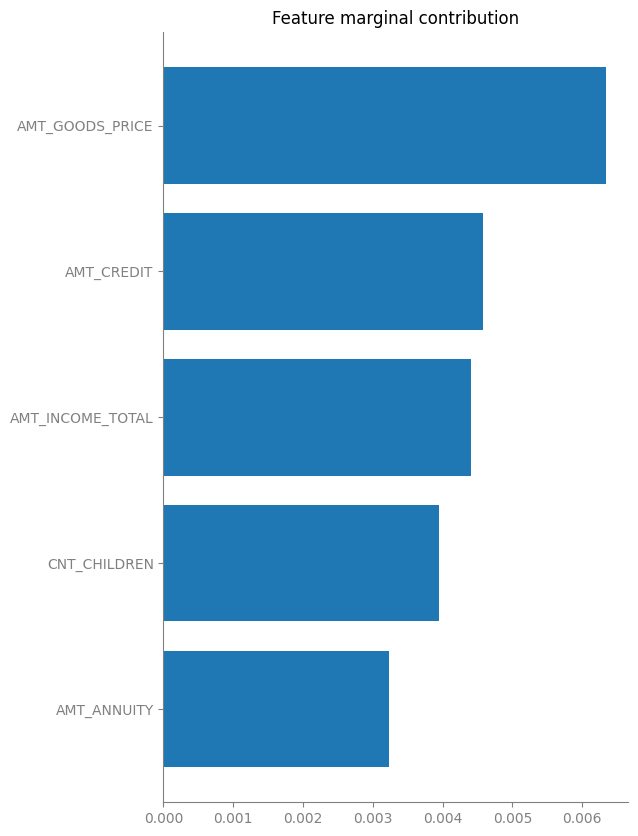

In [79]:
# feature_perm_importance = sorted(zip(cols_pred, pi['importances_mean']), key=lambda x: x[1], reverse=False)

plt.figure(figsize=(6,10))
ax = plt.subplot(1,1,1)
ax.barh(range(len(marginal_contribution)), [imp for p, imp in marginal_contribution])
ax.set_yticks(range(len(marginal_contribution)))
ax.set_yticklabels([p for p, imp in marginal_contribution])

ax.set_title('Feature marginal contribution')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='x', colors='gray')
ax.tick_params(axis='y', colors='gray')

plt.show()

## PDP plots - NAHRAZUJI HODNOTY TOHO REGRESORU RUZNYMI HODNOTAMI A SLEDUJI JAK NA TO REAGUJE PREDIKCE
- PDP = Partial Dependence Plot

In [80]:
def partial_dependency(bst, X, y, feature_names, feature_ids = [], f_id = -1):

    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """
    X_temp = X.copy()
    grid = np.linspace(
        np.percentile(X_temp[:, f_id], 0.1),
        np.percentile(X_temp[:, f_id], 99.5),
        50
    )
    y_pred = np.zeros(len(grid))

    if len(feature_ids) == 0 or f_id == -1:
        print ('Input error!')
        return
    else:
        for i, val in enumerate(grid):

            X_temp[:, f_id] = val
            data = xgb.DMatrix(X_temp, feature_names = feature_names)

            y_pred[i] = np.average(bst.predict(data))

    return grid, y_pred

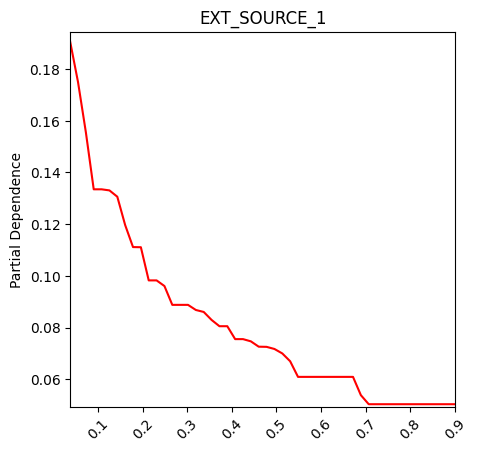

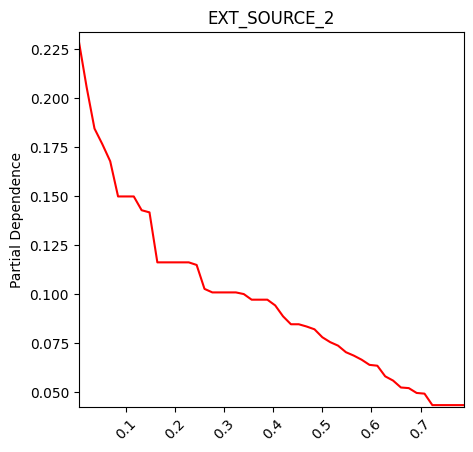

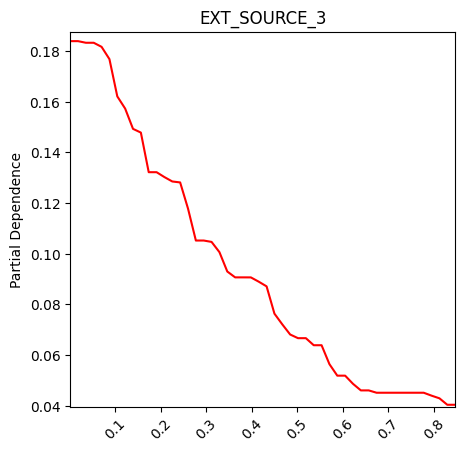

In [81]:
lst_f = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
# cols_pred
sampled_data = data.sample(frac=0.1, random_state=22)
for f in lst_f:
    f_id = cols_pred.index(f)
    feature_ids = range(len(cols_pred))

    mask = sampled_data[f].notnull()
    grid, y_pred = partial_dependency(
        booster,
        sampled_data[mask][cols_pred].values,
        sampled_data[mask][col_target].values,
        feature_names = cols_pred,
        feature_ids = feature_ids,
        f_id = f_id
    )

    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)

    ax.plot(grid, y_pred, ls = '-', color = 'red', linewidth = 1.5, label='fit')

    ax.set_xlim(min(grid), max(grid))
    ax.set_ylim(0.98 * min(y_pred), 1.02 * max(y_pred))

    ax.set_title(f)
    ax.set_ylabel('Partial Dependence')
    plt.xticks(rotation=45)

    plt.show()

## ICE plots
- ICE = Individual Conditional Expectation

In [82]:
def ice_data(bst, dt, predictor, n_points=20):
    X = dt.copy()
    grid = np.linspace(
        dt[predictor].quantile(0.01),
        dt[predictor].quantile(0.99),
        n_points
    )
    
    y_pred = np.zeros((len(dt), len(grid)))

    if len(feature_ids) == 0 or f_id == -1:
        print ('Input error!')
        return
    else:
        for i, val in enumerate(grid):
            X[predictor] = val
            data = xgb.DMatrix(X, feature_names = X.columns.to_list())

            y_pred[:,i] = bst.predict(data)
    return grid, y_pred

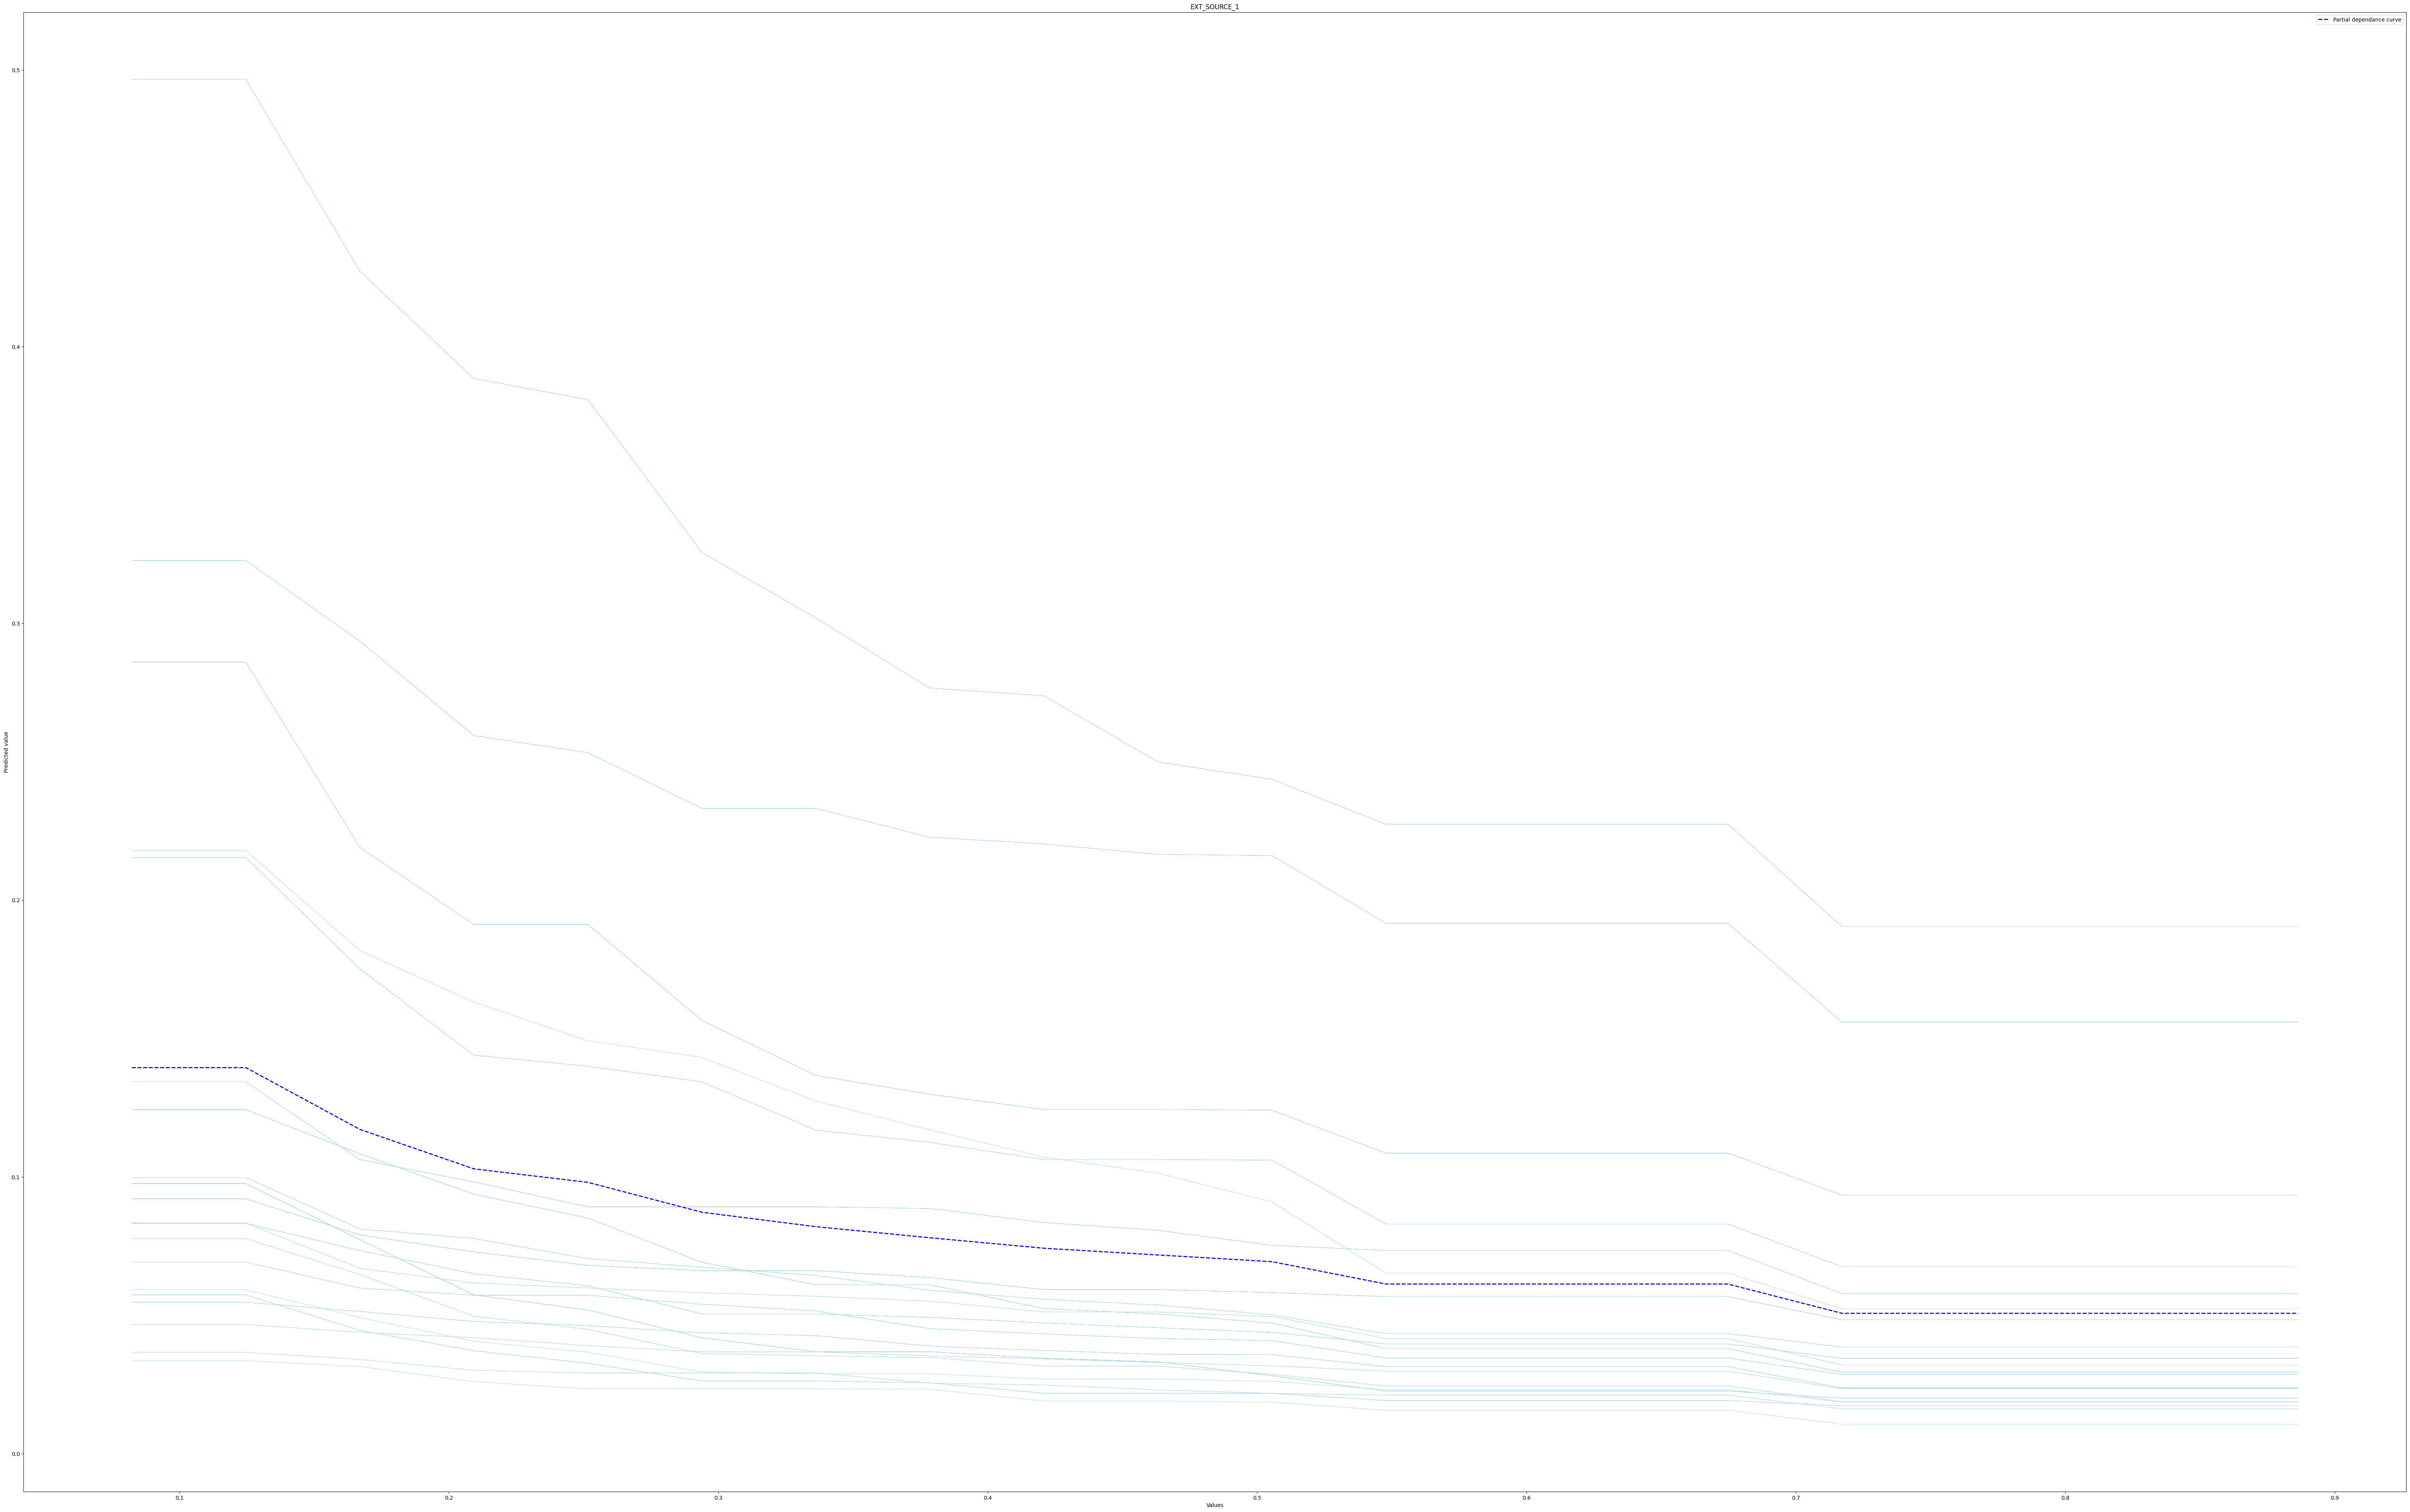

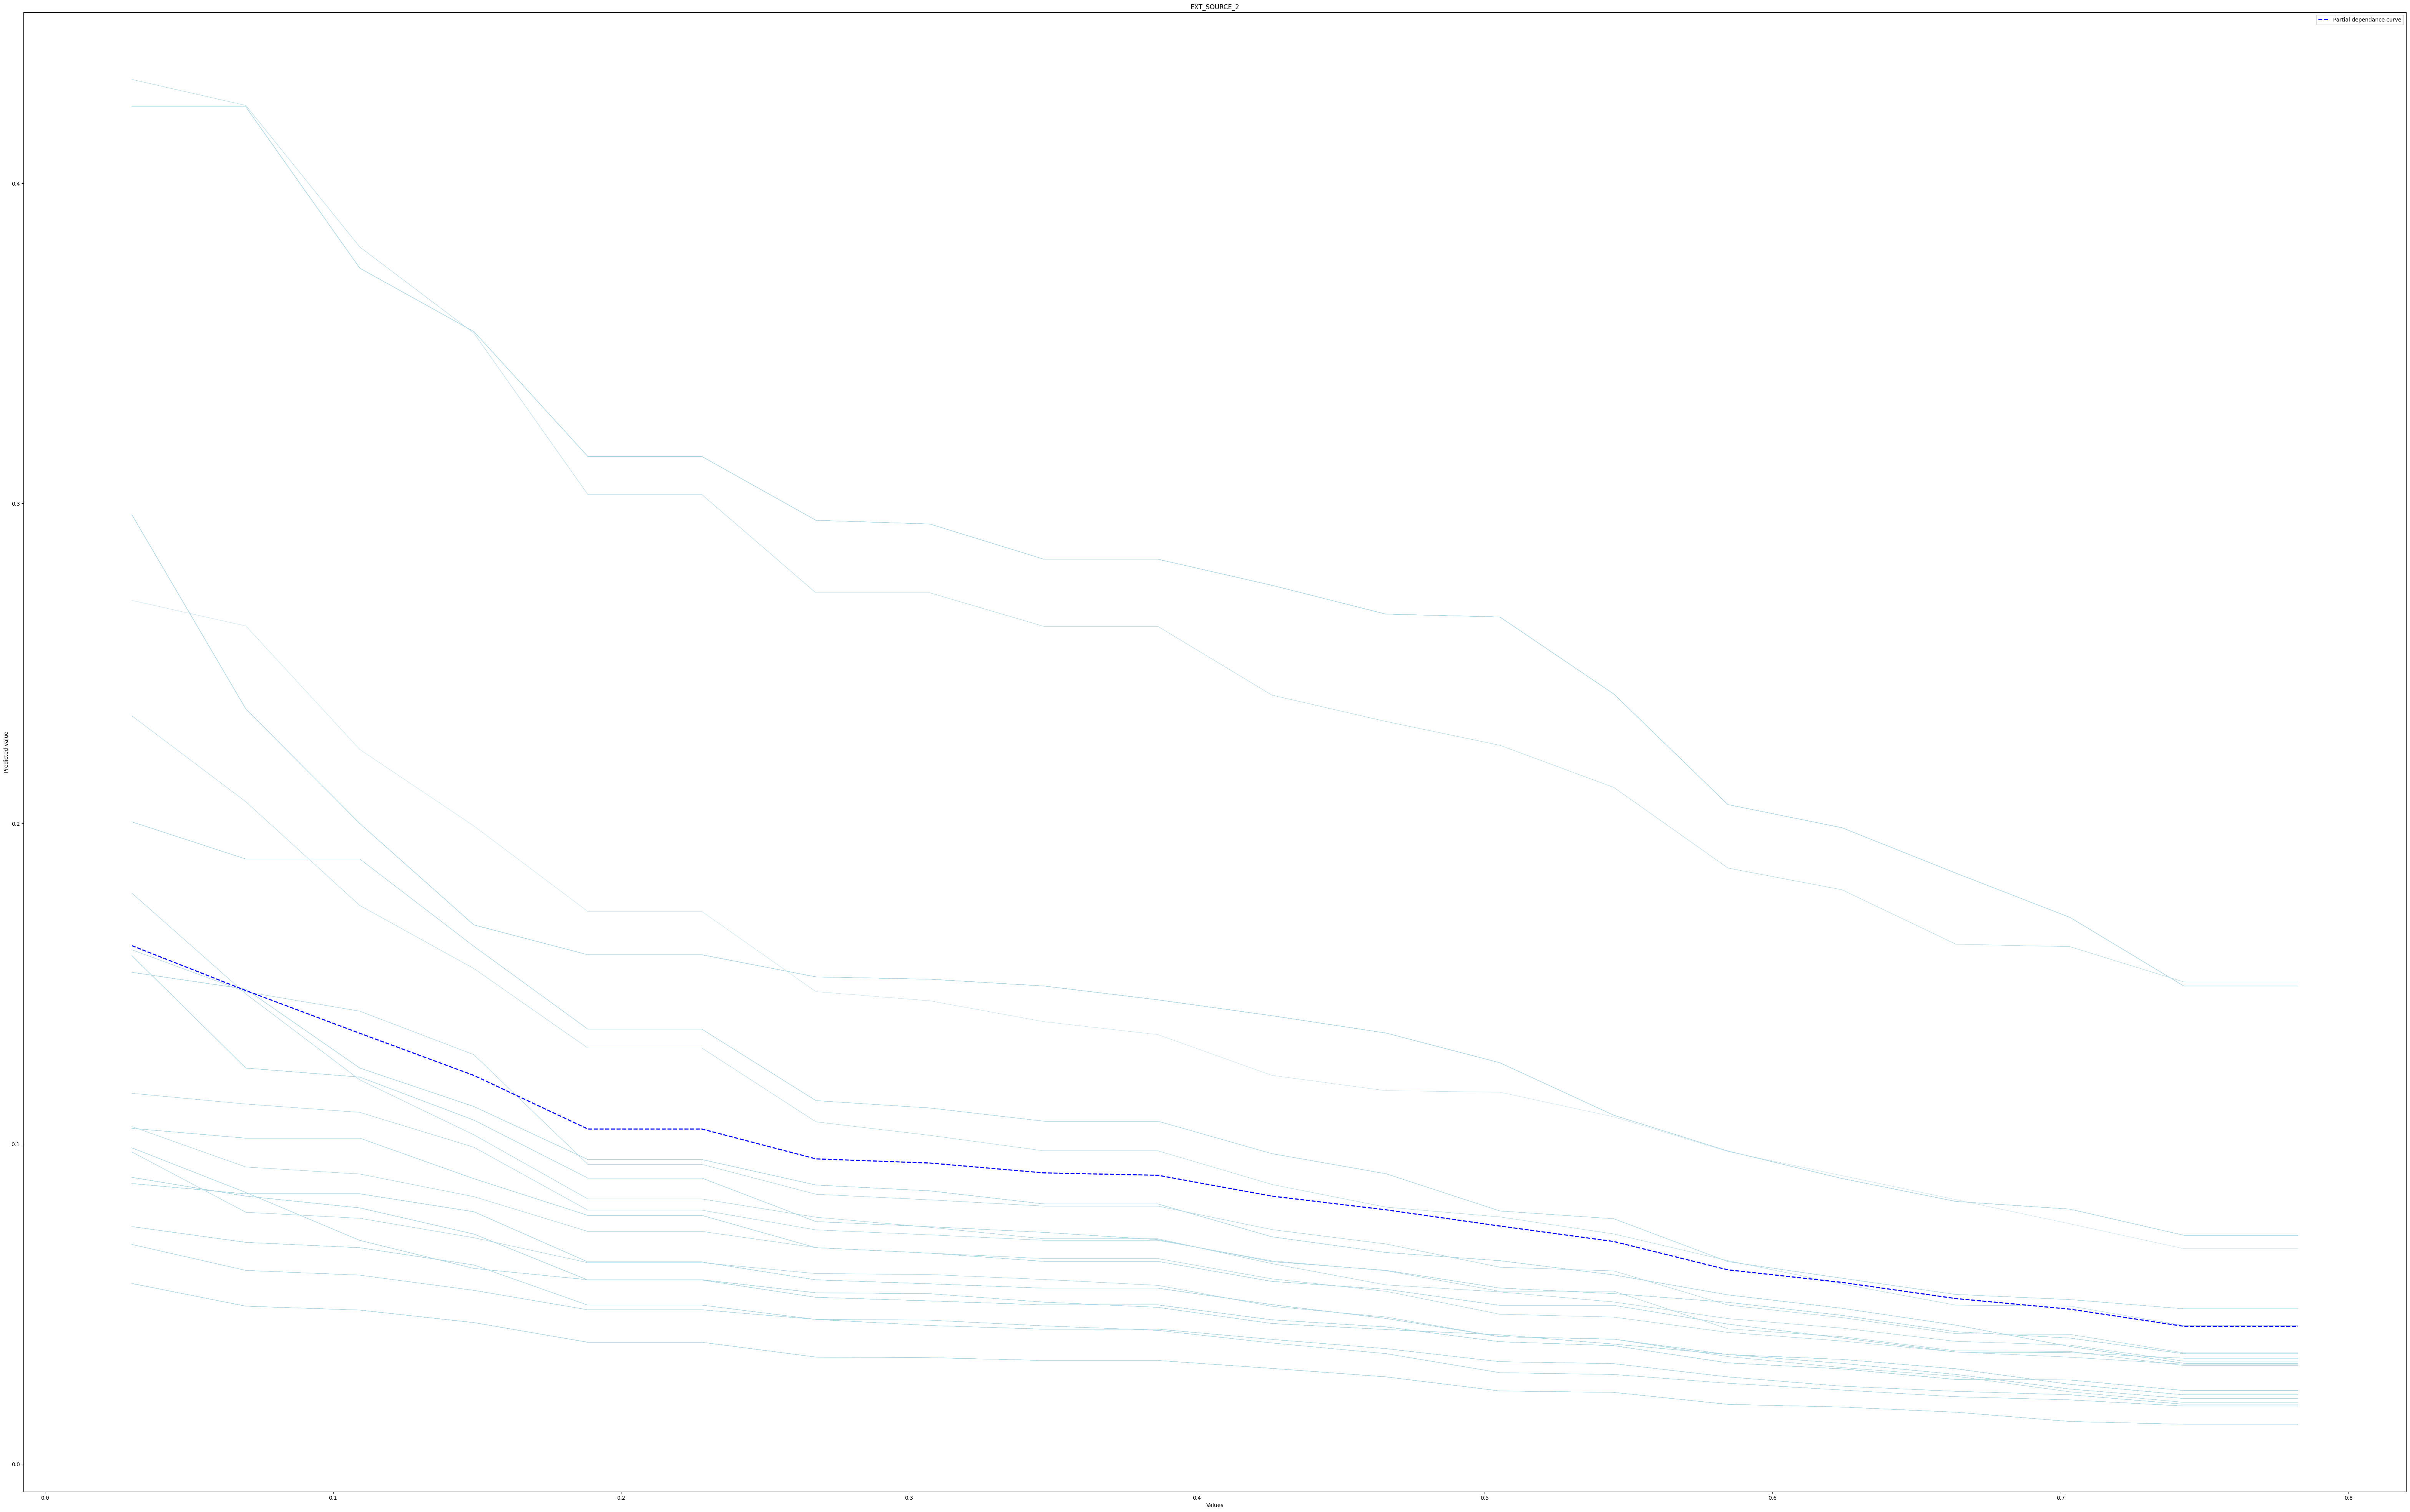

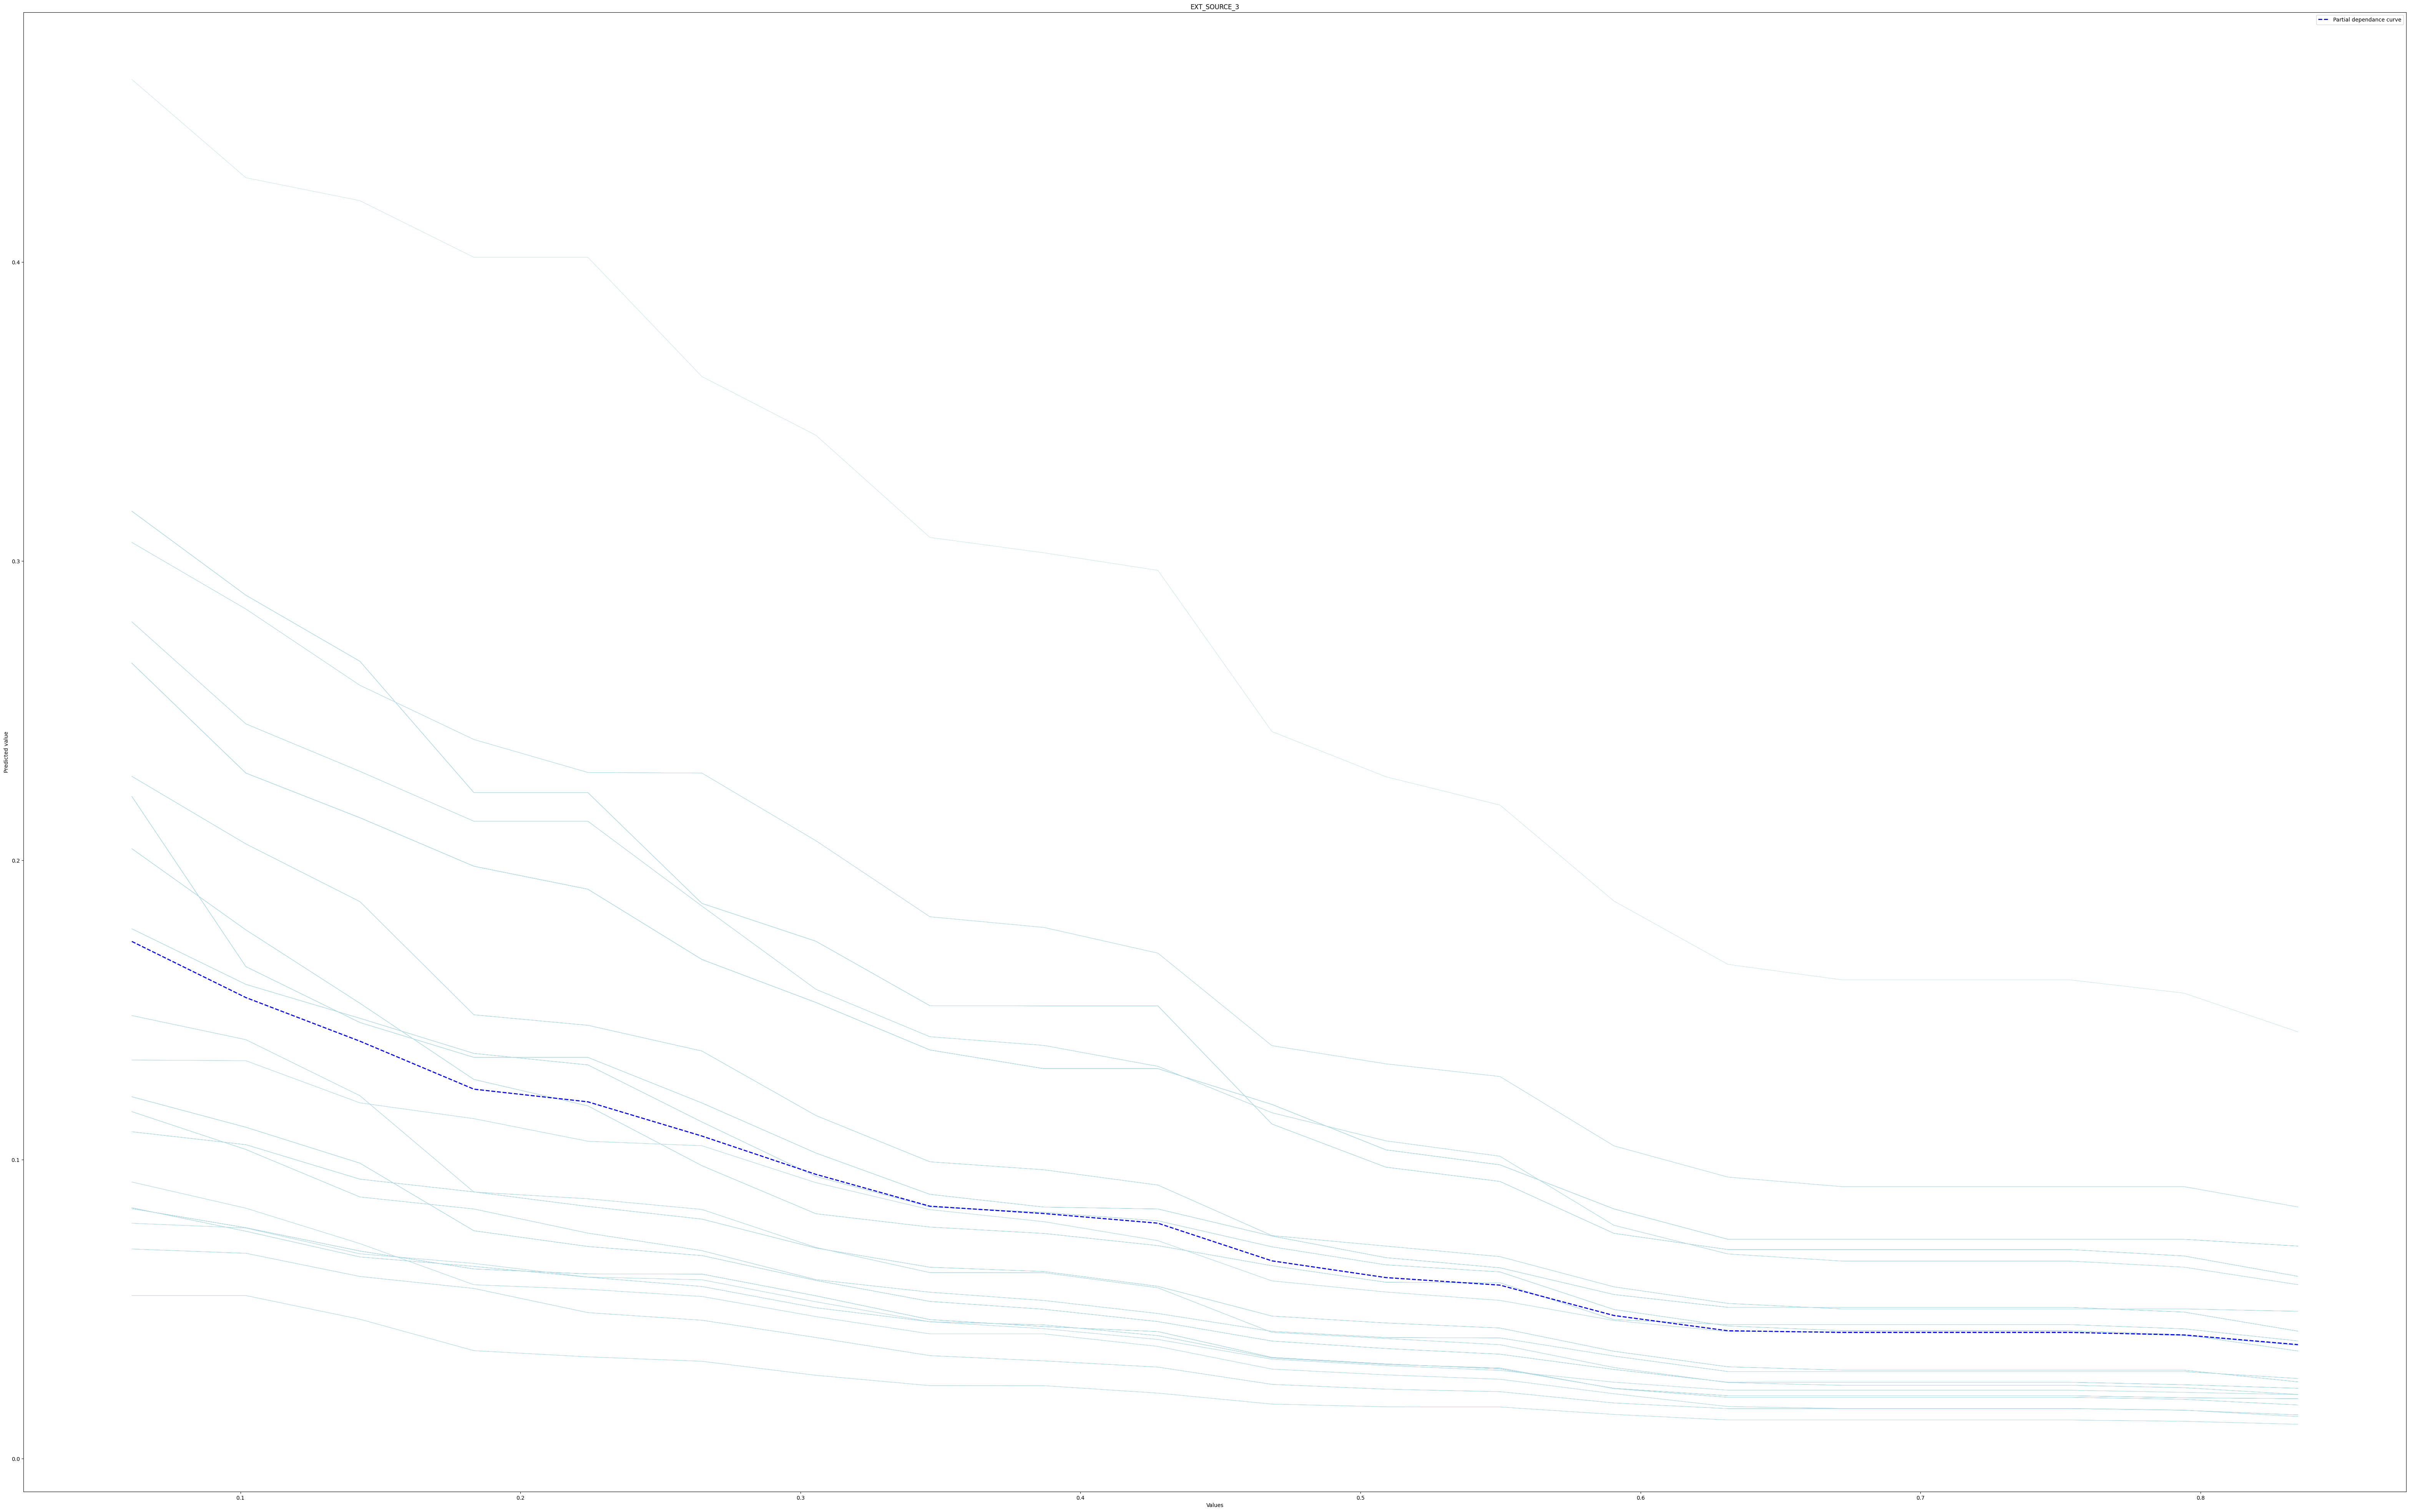

In [83]:
n_plots = 100
cols_to_plot = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

sampled_data = data.sample(n=10000, random_state=22)

for pred in cols_to_plot:
    x, ice_data_plot = ice_data(booster, sampled_data[cols_pred], pred)

    idx = np.random.randint(len(x), size=n_plots)
    plt.plot(x, np.transpose(ice_data_plot[idx,:]), lw = 0.5, color = 'lightblue')
    plt.plot(x, np.average(ice_data_plot[idx,:], axis = 0), lw = 2, ls = '--', color = 'blue', label = 'Partial dependance curve')
    plt.title(pred)
    plt.ylabel('Predicted value')
    plt.xlabel('Values')
    plt.legend(loc='best')
    plt.show()

## SHAP - NEJPROPRACOVANĚJŠÍ SYSTÉM HODNOCENÍ (?)
- SHAP = SHapley Additive exPlanations
- Original paper presenting SHAP values can be downloaded here: <a href=https://arxiv.org/abs/1705.07874 target="_blank">SHAP values</a>
- SHAP values are defined by following equation:
$$ \phi_i = \sum_{S\subseteq F\setminus\lbrace i \rbrace} \frac{|S|!(|F|-|S|-1)!}{|F|!} [f_{S\cup \lbrace i\rbrace}(x_{S\cup \lbrace i\rbrace})-f_S(x_S)] $$
where:

    - $F$ ... set of all model features
    - $S$ ... $S \subseteq F \setminus\lbrace i\rbrace$
    - $\phi_i$ ... SHAP value for predictor $x_i$
    - $f_S(x_S)$ ... output of model build on feature set $S$ given feature values $x_S$

In [84]:
import shap
shap.initjs()

In [85]:
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(data[cols_pred])

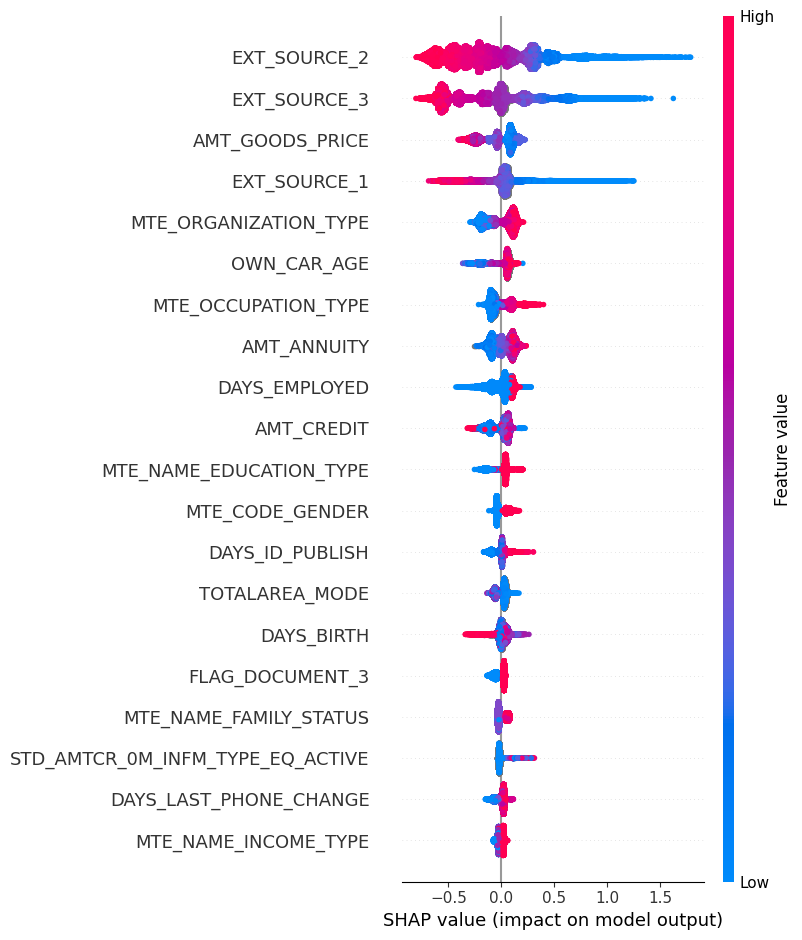

<function matplotlib.pyplot.show(close=None, block=None)>

In [87]:
plt.figure()
shap.summary_plot(shap_values, data[cols_pred], max_display=20, show=True)
plt.show # TADY NAPŘIKLAD NIZKE HODNOTY EXT SOURCE 2 ZVYSUJI VYRAZNE RIZIKO

In [88]:
shap.force_plot(explainer.expected_value, shap_values[0,:], data[cols_pred].iloc[0,:])

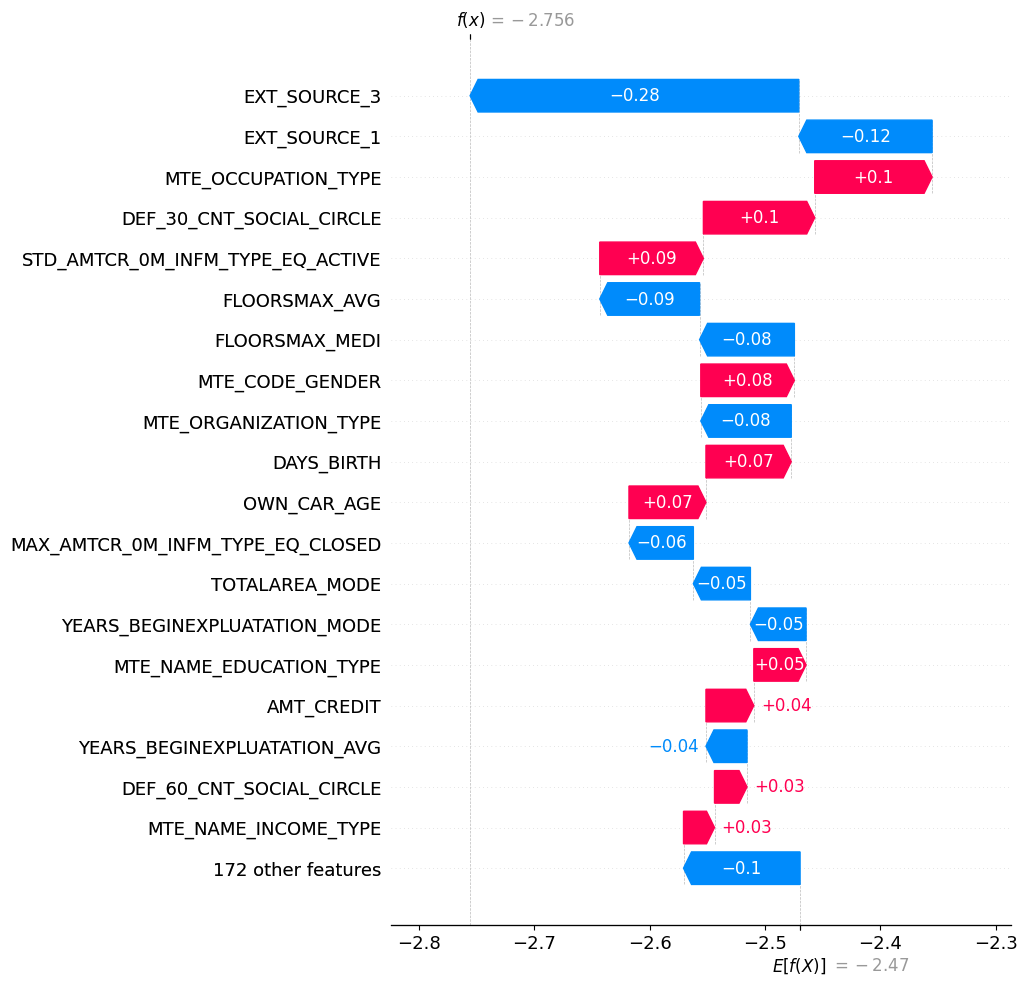

In [89]:
shap.plots._waterfall.waterfall_legacy(
    expected_value=explainer.expected_value, 
    shap_values=shap_values[0, :], 
    feature_names=cols_pred, 
    max_display=20
)

### SHAP interaction values

In [90]:
Xd = xgb.DMatrix(data[train_mask][cols_pred].iloc[:1000], data[train_mask][col_target].iloc[:1000])

explainer = shap.TreeExplainer(booster)
shap_interaction_values = explainer.shap_interaction_values(Xd)

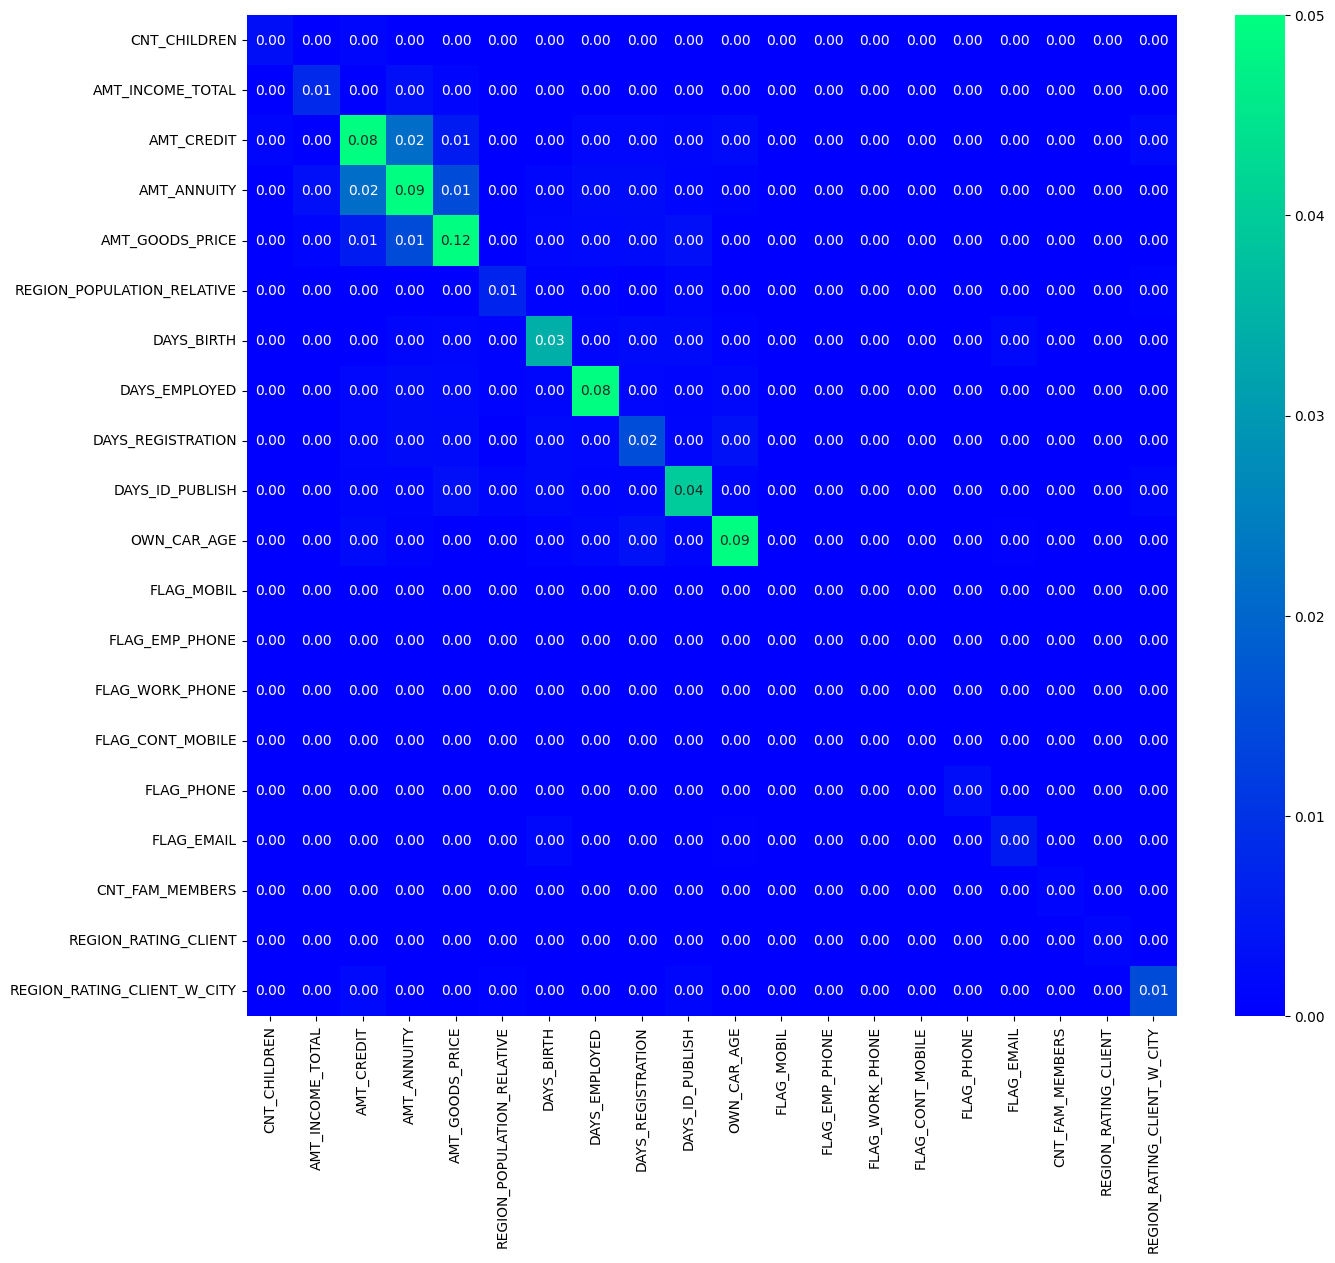

In [91]:
plt.figure(figsize=(15,13))

sns.heatmap(
    data=np.mean(abs(shap_interaction_values[:, 0:20, 0:20]), axis=0), 
    annot=True, 
    fmt='.2f', 
    xticklabels=cols_pred[0:20], 
    yticklabels=cols_pred[0:20],
    cmap='winter',
    vmax=0.05
)

plt.show()

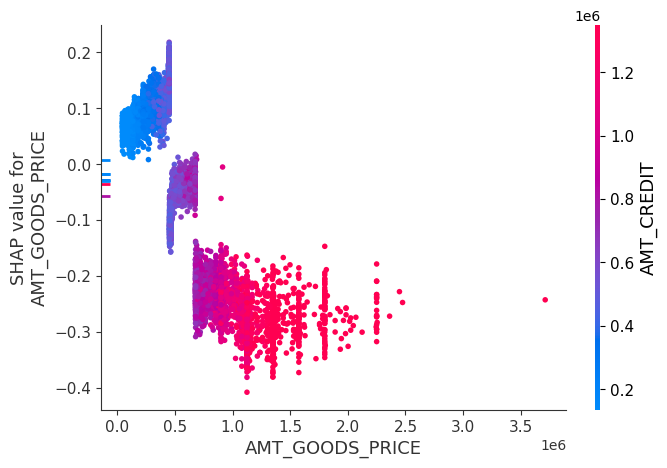

In [92]:
n_observations = 10000

dt_shap = data.iloc[0:n_observations]
dt_shap = dt_shap[cols_pred]
shap.dependence_plot('AMT_GOODS_PRICE', shap_values[:n_observations], dt_shap, interaction_index = 'AMT_CREDIT')

Better example of high interaction: https://h1ros.github.io/posts/explain-the-interaction-values-by-shap/

In [ ]:
# def marginal_dependence(data, predictor, bins, col_target):
#     dt = data.copy()
#     dt[predictor + 'bin'] = pd.qcut(dt[predictor], bins).copy()
#     dt.groupby(predictor + 'bin').agg(
#         def_rt=(col_target, np.mean),
#     ).plot(figsize=(9, 6))